# 1. Introduction

This is a dataset for the credit card fraud transaction detection. It contains synthetic data for the [Capital One](https://www.capitalone.com/) Data Scientist Recruiting process.

## 1.1. Objective
- It's a binary classification problem where we need to predict whether a transaction is a fraud or not.
- Our business sense making purpose should be to minimize the total loss dollar amount due to fraud with the most parsimonious total number of transactions flagged as suspicious. In this way, the non-fraud real business transactions will be exposed to the minimal level of impact possible. In another word, we'd like to achieve a balance between precision and recall, so F1-score will be used as the leading metric.

## 1.2. Data Description
- The dataset is saved in the JSON format in a .txt file and will render a dataframe with a fair dimension of 786,363 x 29 after loading.
- The label (isFraud) is hugely imbalanced with less than 2% of fraudulent transactions. We'd use both undersample the non-fraud transactions and oversample the fraud transactions to deal with the imbalance issue and compare their performances. 
- 

# 2. Module Management, Data Import

Since the dataset is in the JSON format, we will use the pandas.read_json() method to load the data while preserving the datatime and string/categorical columns to their belonging datatypes. Given the synthetic nature of the dataset, any duplicate rows will be dropped. We will also check the data types, missing values, and the distribution of the numerical and the cardinality of the categorical variables.

In [68]:
# data manipulation
import pandas as pd
import numpy as np
import scipy as sp
# syntax encoding
import json
pd.options.mode.copy_on_write = True
# computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
from tqdm import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations
from sklearn.base import clone
import optuna
import logging

In [99]:
# modeling
import shap
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve,  f1_score, confusion_matrix, classification_report
# from imblearn.under_sampling import RandomUnderSampler # imbalance-learn is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.
from catboost import CatBoostClassifier, Pool


In [6]:
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Aesthetics
sns.set_style("ticks")
sns.color_palette("husl", 8)
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = 25
pd.options.display.max_rows = 30

In [5]:
file_path = 'transactions/transactions.txt'
df = pd.read_json(file_path, lines=True, convert_dates=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'],
                  dtype={'accountNumber': str, 'customerId': str, 'creditLimit': float, 'availableMoney': float, 'transactionAmount': float, 'currentBalance': float
                         , 'cardCVV': str, 'enteredCVV': str, 'cardLast4Digits': str, 'transactionType': str, 'echoBuffer': str, 'currentExpDate': str, 'accountOpenDate': str
                         , 'dateOfLastAddressChange': str, 'cardPresent': bool, 'expirationDateKeyInMatch': bool, 'isFraud': bool, 'echoBuffer': str, 'merchantCity': str
                         , 'merchantState': str, 'merchantZip': str, 'posOnPremises': str, 'recurringAuthInd': str, 'merchantCategoryCode': str, 'transactionDateTime': str
                         , 'merchantName': str, 'acqCountry': str, 'merchantCountryCode': str, 'posConditionCode': str, 'posEntryMode': str, 'transactionType': str, 'cardPresent': bool
                         , 'isFraud': bool})
df.shape

(786363, 29)

In [6]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,...,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,...,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,...,3143,PURCHASE,,0.0,,,,True,,,False,False


# 3 Data Preprocessing

## 3.1 Label overview
Only about 1.58% of the transactions are fraudulent. 
- Two classes are highly imbalanced.
- No missing values in the label column.
- Convert the boolean to 0 and 1 for the convenience of modeling.

In [7]:
# check the ratio of the binary target column
df.isFraud.value_counts() / df.shape[0]

isFraud
False    0.98421
True     0.01579
Name: count, dtype: float64

In [8]:
# check the missing values in the label column, which should be 0
a = df['isFraud'].isnull().sum()
print(f'The target label has {a} missing values.')

The target label has 0 missing values.


Convert the boolean label column to binaries. 0 for non-fraudulent transactions and 1 for fraudulent transactions.   

In [9]:
# split the df into y the target column and x the feature columns
y = df['isFraud'].astype(int)
x = df.drop(labels='isFraud', axis=1)

Generally, if the cardinality of a categorical feature is closer to 1 or the number of rows, it's less informative. We will exclude the non-informative columns and re-construct the verbose ones before modeling. 

In [10]:
# check the cardinality of the x columns
x.nunique().sort_values(ascending=False)

transactionDateTime         776637
availableMoney              521915
currentBalance              487318
transactionAmount            66038
cardLast4Digits               5246
accountNumber                 5000
customerId                    5000
merchantName                  2490
dateOfLastAddressChange       2184
accountOpenDate               1820
enteredCVV                     976
cardCVV                        899
currentExpDate                 165
merchantCategoryCode            19
creditLimit                     10
posEntryMode                     6
merchantCountryCode              5
acqCountry                       5
transactionType                  4
posConditionCode                 4
cardPresent                      2
expirationDateKeyInMatch         2
echoBuffer                       1
merchantCity                     1
merchantState                    1
merchantZip                      1
posOnPremises                    1
recurringAuthInd                 1
dtype: int64

## 3.2 Numerical variables overview
The as-is dataset has 4 numerical variables. The post-preprocessed dataset will also have 3 numerical variables: ['availableMoney', 'transactionAmount', 'currentBalance'].
- Albeit ['creditLimit'] seems to be a numerical variable, it's more like a categorical variable with a small number of unique values. We will treat it as a categorical variable.
- None of the numerical variables have to worry about missing values.
- From the statistics, we can see that the as is columns have wide ranges. Consider both outlier imputation and scaling on non-tree based approaches.
- The histogram shows that they are all considerably right-skewed. We may consider a Box-Cox transformation.

In [11]:
# Verify the numerical columns are missing value free
x_num = x[['availableMoney', 'transactionAmount', 'currentBalance']]
x_num.isnull().sum()

availableMoney       0
transactionAmount    0
currentBalance       0
dtype: int64

In [12]:
# check the statistics of the numerical columns
x_num.describe()

,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000
mean,6250.725369,136.985791,4508.739089
std,8880.783989,147.725569,6457.442068
min,-1005.630000,0.000000,0.000000
25%,1077.420000,33.650000,689.910000
50%,3184.860000,87.900000,2451.760000
75%,7500.000000,191.480000,5291.095000
max,50000.000000,2011.540000,47498.810000


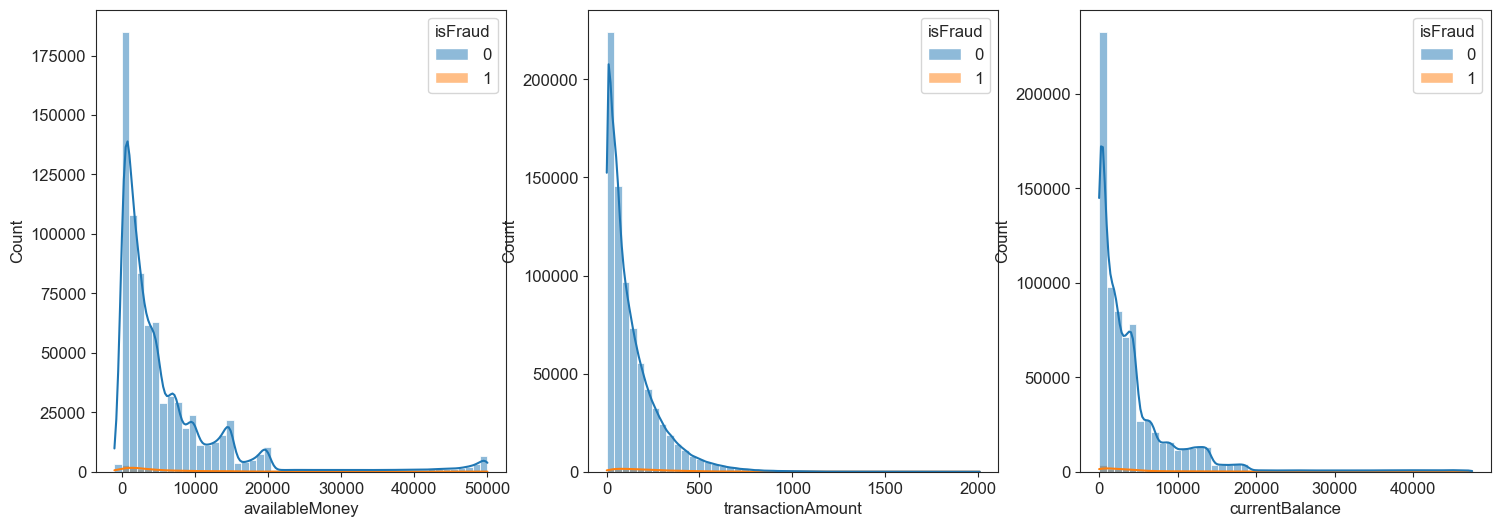

In [13]:
# histogram the numerical columns
x_num_y = pd.concat([x_num, y], axis=1)
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(x_num_y, x='availableMoney', kde=True, ax=ax[0], bins=50, hue='isFraud')
sns.histplot(x_num_y, x='transactionAmount', kde=True, ax=ax[1], bins=50, hue='isFraud')
sns.histplot(x_num_y,x='currentBalance', kde=True, ax=ax[2], bins=50, hue='isFraud')
plt.show()


## 3.3 Categorical variables overview

The as-is dataset has 25 non-numerical variables, 4 datetime, 21 categorical/boolean. 

- There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags.
- The columns ['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'] are supposed to be datetimes. Cconvert them to datetime objects.
- Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to 0s and 1s.
- Conver the ['creditLimit'] column to a integer then string

In [14]:
# deselect numerical columns and concatenate the creditLimit column to x_cat
x_cat = x.select_dtypes(exclude='number')
x_cat['creditLimit'] = x['creditLimit'].astype(int).astype(str)
x_cat.head()

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,creditLimit
0,737265056,737265056,2016-08-13 14:27:32,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,,,,False,,,False,5000
1,737265056,737265056,2016-10-11 05:05:54,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,True,,,False,5000
2,737265056,737265056,2016-11-08 09:18:39,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False,5000
3,737265056,737265056,2016-12-10 02:14:50,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False,5000
4,830329091,830329091,2016-03-24 21:04:46,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False,5000


In [15]:
# replace empty strings with np.nan while downcasting the changed columns' data types
pd.set_option('future.no_silent_downcasting', True)
x_cat = x_cat.replace(r'^\s*$', np.nan, regex=True)
df = df.replace(r'^\s*$', np.nan, regex=True)

In [16]:
# convert the datetime columns to datetime objects in df
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [17]:
# Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to integers of binary in x_cat and df
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [18]:
# convert the ['creditLimit'] column to an integer then string
df['creditLimit'] = df['creditLimit'].astype(int).astype(str)

## 3.4 Duplicate rows/transactions check

- There are no strict duplicate rows in the dataset.
- However, if we drop the Time from the DateTime, we will have 92500 duplicate rows. We address them by almost indentical duplicates. 
- There are two transactionTypes, reversal and multi-swipe, which can contain very similar transactions in short time periods. We will pay special attention to them in the EDA phase.
- **We KEEP the almost identical dupicates in our model.** This decision is based on that real-life data most definitely contains those types of transactions and we aim to build a predictive model that can thrive in handling realistic scenarios.  

In [19]:
df.duplicated().sum()

0

## 3.5 Outliers 
- As aforementioned, the numerical columns display wide ranges and gigantic skewness. So, it's imperative to perform some sort of transformations to make them more Gaussian-like. We pick the Box-Cox transformation, then use eye-balling and a wider than normally used Tukey's fences method to detect the outliers.
- It's obvious that our 3 numerical columns are highly correlated by definition. Thus, we only need to detect and handle the outliers for the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns.
- Since we plan to work with Box-Cox transformed columns in the modeling phase, so we will be conservative in the outlier detection and cap them by the Tukey's fences method with 2 times of IQR instead of 1.5 time.
- As a result, 11 outliers are detected with transaction amount higher than \$1680, and they are all non-fraudulent transactions. They are deleted for now.


In [20]:
# As aforementioned, the numerical columns display wide ranges and gigantic right-skewness. So, we will the modified Box-Cox transformation to cope with negative values to make the data more Gaussian-like to help us with the outlier detection.
# Box-Cox transform ['availableMoney', 'transactionAmount', 'currentBalance'] columns in x_num with lambda=0.25. Notice that some of the 'availableMoney' are negative with a minimum of -1005.6, so we need to add a constant to make them all non-negative.
x_num_bc = x_num.copy()
x_num_bc['bc_availableMoney'] = sp.stats.boxcox(x_num_bc['availableMoney']+1005.6, lmbda=0.25)
x_num_bc['bc_transactionAmount'] = sp.stats.boxcox(x_num_bc['transactionAmount'], lmbda=0.25)
x_num_bc['bc_currentBalance'] = sp.stats.boxcox(x_num_bc['currentBalance'], lmbda=0.25)
# drop the original columns
x_num_bc.drop(columns=['availableMoney','transactionAmount','currentBalance'], inplace=True)
# hstack x_xum_bc with y
x_num_bc_y = pd.concat([x_num_bc, y], axis=1)
# check the statistics of the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
x_num_bc.describe()

,bc_availableMoney,bc_transactionAmount,bc_currentBalance
count,786362.000000,786363.000000,786363.000000
mean,29.692358,8.045755,23.426929
std,8.348273,4.109909,11.235238
min,5.621801,-4.000000,-4.000000
25%,23.022987,5.633991,16.500200
50%,28.182927,8.247775,24.146829
75%,34.413708,10.879586,30.115079
max,56.112454,22.788115,55.051465


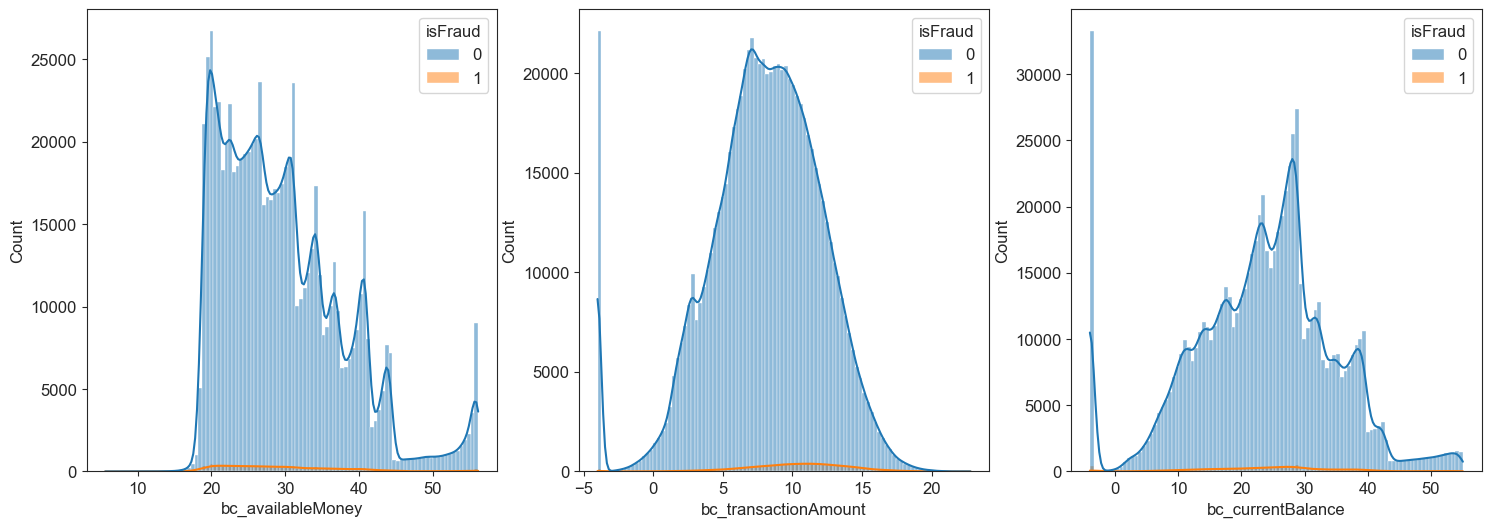

In [21]:
# use seaborn to check the histograms of the Box-Cox transformed ['availableMoney','transactionAmount','currentBalance'] columns of isFraud=0 or 1  group separately with the kde on 
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(x_num_bc_y, x='bc_availableMoney', hue='isFraud', kde=True, ax=ax[0], bins=100)
sns.histplot(x_num_bc_y, x='bc_transactionAmount', hue='isFraud', kde=True, ax=ax[1], bins=100)
sns.histplot(x_num_bc_y, x='bc_currentBalance', hue='isFraud', kde=True, ax=ax[2], bins=100)
plt.show()

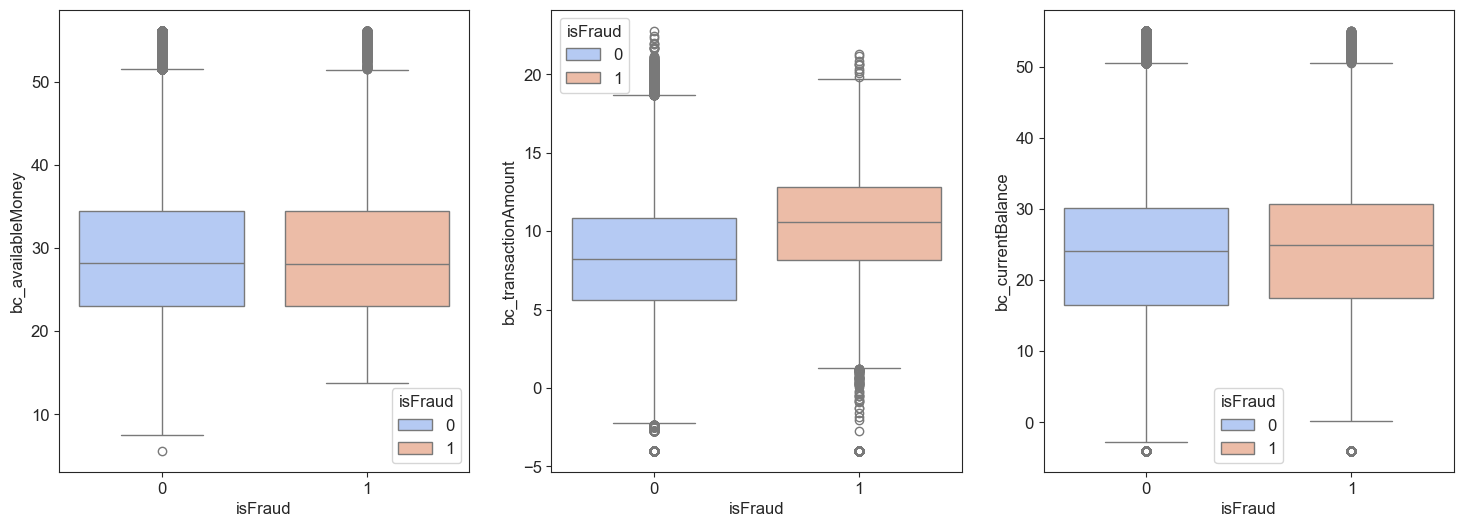

In [22]:
# use sns to plot the boxplot of the Box-Cox transformed ['availableMoney','transactionAmount','currentBalance'] columns isFraud=0or1 group with different color
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.boxplot(x='isFraud', y='bc_availableMoney', data=x_num_bc_y, ax=ax[0], hue='isFraud', palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_transactionAmount', data=x_num_bc_y, ax=ax[1], hue='isFraud',palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_currentBalance', data=x_num_bc_y, ax=ax[2], hue='isFraud',palette='coolwarm')
plt.show()

In [23]:
# use the Tukey's fense method to detect the outliers in the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
k = 2
def tukey_fences(x, k):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))
a = tukey_fences(x_num_bc['bc_availableMoney'],k=k).sum()
b = tukey_fences(x_num_bc['bc_transactionAmount'],k=k).sum()
c = tukey_fences(x_num_bc['bc_currentBalance'],k=k).sum()
print(f'bc_creditLimit has {a} outliers when we set the k = {k}.')
print(f'bc_transactionAmount has {b} outliers when we set the k = {k}.')
print(f'bc_availableMoney has {c} outliers when we set the k = {k}.')

bc_creditLimit has 0 outliers when we set the k = 2.
bc_transactionAmount has 11 outliers when we set the k = 2.
bc_availableMoney has 0 outliers when we set the k = 2.


In [24]:
# Since the outliers come from large transactions, let us find the top 11 transactions with the largest transactionAmount
outlier_index = x_num.nlargest(11, 'transactionAmount').index
x_num.loc[outlier_index].sort_values(['transactionAmount'], ascending=False)

,availableMoney,transactionAmount,currentBalance
380125,47991.66,2011.54,2008.34
498620,18259.98,1905.30,1740.02
673073,10484.42,1873.97,4515.58
778423,9006.27,1780.60,993.73
424567,1129.87,1772.63,1370.13
612391,4225.92,1767.50,10774.08
679917,346.02,1710.13,4653.98
371878,142.21,1707.80,357.79
308817,480.98,1704.55,19.02
501537,15000.00,1693.36,0.00


In [25]:
df.loc[outlier_index,['transactionAmount','isFraud']].sort_values(['transactionAmount'], ascending=False)

,transactionAmount,isFraud
380125,2011.54,False
498620,1905.30,False
673073,1873.97,False
778423,1780.60,False
424567,1772.63,False
612391,1767.50,False
679917,1710.13,False
371878,1707.80,False
308817,1704.55,False
501537,1693.36,False


In [26]:
# Since they are all non-fraud, nothing really seem to suspicious, and 11 is trivial compared to the sheer size of 783K rows, we just delete the 11 outliers for now
df.drop(index=outlier_index, inplace=True)
df.reset_index(drop=True, inplace=True)
x_num.drop(index=outlier_index, inplace=True)
x_num.reset_index(drop=True, inplace=True)

## 3.6 Missing values 

- The label column has no missing values.
- The numerical columns have no missing values.
- The categorical columns have missing values. Given the hidden structure between the categorical features, we'd like to be extra conservative and do missing value retrivals univariately and accordingly instead of a multivariate imputation such as via the k-NN imputer or the iterative imputer.
 + 3.6.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
 + 3.6.2 The column ['acqCountry'] has 4562 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be retrieved by the mode of the rows with the same ['accountNumber','cardLast4Digits'] columns' combination primarily or by ['accountNumber'] column itself. In this way, we fill the Nans via linkages within accounts instead of imputation, except for just 1 account. 
 + 3.6.3 The column ['merchantCountryCode'] has 724 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be retrieved via linkage within merchant information as well by the mode of the rows with ['merchantName'] column primarily. Like ['acqCountry'], no imputation is needed after we fill the Nans with the information within the ['merchantName'] column.
 + 3.6.4 The column ['transactionType'] has 698 missing values. Due to lack of other transaction related information and avoiding any arbitrariness, we simply label the missing values as 'Unknown' for now. 
 + 3.6.5 The column ['posConditionCode'] has 409 missing values. Due to the contradicting code from transactions made at the same merchant and avoiding any arbitrariness, we simply label the missing values as 'Unknown' for now.
 + 3.6.6 The column ['posEntryMode'] has 4054 missing values. Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now.  

In [27]:
# screen for missing values in the categorical columns
x_cat.isna().sum().sort_values(ascending=False)

recurringAuthInd            786363
posOnPremises               786363
merchantZip                 786363
merchantState               786363
merchantCity                786363
echoBuffer                  786363
acqCountry                    4562
posEntryMode                  4054
merchantCountryCode            724
transactionType                698
posConditionCode               409
accountNumber                    0
expirationDateKeyInMatch         0
cardPresent                      0
cardCVV                          0
cardLast4Digits                  0
enteredCVV                       0
customerId                       0
dateOfLastAddressChange          0
accountOpenDate                  0
currentExpDate                   0
merchantCategoryCode             0
merchantName                     0
transactionDateTime              0
creditLimit                      0
dtype: int64

### 3.6.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags. Then drop them all.

In [28]:
# drop the six all NaN columns
x_cat.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)

In [29]:
# check the missing values in the rest columns
x_cat.isna().sum().sort_values(ascending=False)

acqCountry                  4562
posEntryMode                4054
merchantCountryCode          724
transactionType              698
posConditionCode             409
accountNumber                  0
cardCVV                        0
expirationDateKeyInMatch       0
cardPresent                    0
cardLast4Digits                0
enteredCVV                     0
currentExpDate                 0
dateOfLastAddressChange        0
accountOpenDate                0
customerId                     0
merchantCategoryCode           0
merchantName                   0
transactionDateTime            0
creditLimit                    0
dtype: int64

### 3.6.2 The column ['acqCountry'] has 4,562 missing values.
- Among the missing values in the 'acqCountry' column, 3.3% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 4,562 transactions with missing values come from 1,495 accounts. 
- We will impute them by the mode of the rows with the same ['accountNumber'] primarily.
- For 1,494 accounts that can have a mode value. Due to the fact the dataset is predominantly from the US customers, their modes are all US actually. 
- The remaining 1 account,'997884003', who has no record of 'acqCountry' only have 3 non-default transactions from apple's appstore, we will assume it with 'US' as well for now. They can also be dropped later on if they are not informative.

In [30]:
# check the missing values in the 'acqCountry' column's distribution by the label column
y[x_cat['acqCountry'].isna()].value_counts()/ y[x_cat['acqCountry'].isna()].shape[0]

isFraud
0    0.967339
1    0.032661
Name: count, dtype: float64

In [31]:
# check the unique values of the 'acqCountry' of all transactions. We can see the 'US' is predominantly dominating in this filed, more than 98.5%. 
x_cat['acqCountry'].value_counts(dropna=False)/x_cat.shape[0]

acqCountry
US     0.985180
NaN    0.005801
MEX    0.003980
CAN    0.003083
PR     0.001956
Name: count, dtype: float64

In [32]:
# check the unique values of the 'accountNumber' of the transactions having missing values in the 'acqCountry' column
a = x_cat[x_cat['acqCountry'].isna()][['accountNumber']].drop_duplicates()
# check the mode of the 'acqCountry' column by the ['accountNumber'] column's group
b = x_cat[x_cat['accountNumber'].isin(a['accountNumber'])][['accountNumber','acqCountry']].groupby(['accountNumber']).agg(pd.Series.mode).astype(str)
b['acqCountry'].value_counts().reset_index()

,acqCountry,count
0,US,1494
1,[],1


In [33]:
b[b['acqCountry'] != 'US']

,acqCountry
accountNumber,
997884003,[]


In [34]:
# check the transactions of the accountNumber '997884003', we can see there is no info on its acqCountry, but the owner shops on the US iTunes store, also given the fact the dataset is predominantly from the US customers, we will assume it with 'US' as well for now.
df[df['accountNumber']=='997884003']

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
107475,997884003,997884003,7500,7500.0,2016-10-27 20:48:49,8.98,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,0,0,False
107476,997884003,997884003,7500,7500.0,2016-11-27 04:49:57,8.98,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,0,0,False
107477,997884003,997884003,7500,7500.0,2016-12-28 23:09:24,8.98,Apple iTunes,NaN,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,0,0,False


In [35]:
# fill the NaNs in 'acqCountry' as US for its missing for all accounts for now
df.loc[df['acqCountry'].isna(),'acqCountry'] = 'US'

### 3.6.3 The column ['merchantCountryCode'] has 724 missing values.
- Among the missing values in the 'acqCountry' column, 1.1% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 724 transactions with missing values come from 293 merchants. 
- We will impute them by the mode of the rows with the same ['merchantName'] primarily.
- Due to the fact the dataset is predominantly from the US merchants, their modes are all US. 

In [36]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['merchantCountryCode'].isna()].value_counts()/ y[x_cat['merchantCountryCode'].isna()].shape[0]

isFraud
0    0.88674
1    0.11326
Name: count, dtype: float64

In [37]:
# check the unique values of the 'merchantCountryCode' of all transactions. We can see the 'US' is predominantly dominating in this filed, more than 99%.
x_cat['merchantCountryCode'].value_counts(dropna=False)/x_cat.shape[0]

merchantCountryCode
US     0.990015
MEX    0.003997
CAN    0.003085
PR     0.001983
NaN    0.000921
Name: count, dtype: float64

In [38]:
# check the unique values of the ['merchantName','merchantCategoryCode'] of the transactions having missing values in the 'merchantCountryCode' column
a = x_cat[x_cat['merchantCountryCode'].isna()][['merchantCountryCode','merchantName','merchantCategoryCode']].drop_duplicates()
# check the mode of the 'merchantCountryCode' column by the 'merchantName' column's group
b = x_cat[x_cat['merchantName'].isin(a['merchantName'])][['merchantName','merchantCountryCode']].groupby(['merchantName']).agg(pd.Series.mode).astype(str)
b['merchantCountryCode'].value_counts().reset_index()

,merchantCountryCode,count
0,US,293


In [39]:
# impute 'merchantCountryCode' as US for its missing for all merchants
df.loc[df['merchantCountryCode'].isna(),'merchantCountryCode'] = 'US'

### 3.6.4 The column ['transactionType'] has 698 missing values.
- Among the missing values in the 'acqCountry' column, 2.0% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to lack of relative information, we simply label the missing values as 'Unknown' for now. 

In [40]:
# check the missing values in the ['transactionType'] column's distribution by the label column
y[x_cat['transactionType'].isna()].value_counts()/ y[x_cat['transactionType'].isna()].shape[0]

isFraud
0    0.979943
1    0.020057
Name: count, dtype: float64

In [41]:
# check the unique values of the 'transactionType' of all transactions. We can see the 'PURCHASE' is dominating in this filed with about 94.8%. So, imputing with the mode is a no longer as solid as before, especially when the missing values are not negligible and other features cannot provide a clue.
x_cat['transactionType'].value_counts(dropna=False)/x_cat.shape[0]

transactionType
PURCHASE                0.947645
REVERSAL                0.025819
ADDRESS_VERIFICATION    0.025648
NaN                     0.000888
Name: count, dtype: float64

In [42]:
# impute 'transactionType' as 'Unknown' for its missing for all transactions
df.loc[df['transactionType'].isna(),'transactionType'] = 'Unknown'

### 3.6.5 The column ['posConditionCode'] has 409 missing values.
- Among the missing values in the 'acqCountry' column, 5.4% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the contradicting code from transactions made at the same merchant, we simply label the missing values as 'Unknown' for now. 

In [43]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['posConditionCode'].isna()].value_counts()/ y[x_cat['posConditionCode'].isna()].shape[0]

isFraud
0    0.94621
1    0.05379
Name: count, dtype: float64

In [44]:
# check the unique values of the 'posConditionCode' of all transactions. We can see the '01' is dominating in this filed with about 80%. So, imputing with the mode is a no longer as solid as before.
x_cat['posConditionCode'].value_counts(dropna=False)/x_cat.shape[0]

posConditionCode
01     0.799614
08     0.190286
99     0.009580
NaN    0.000520
Name: count, dtype: float64

In [45]:
# check the unique values of the 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['posConditionCode'].isna(),['merchantName']].value_counts(dropna=False).head(10) 

merchantName     
Shell Gas #256420    25
Lyft                 19
walmart.com          15
Uber                 13
cheapfast.com        12
discount.com         12
gap.com              11
alibaba.com           8
sears.com             8
Apple iTunes          8
Name: count, dtype: int64

In [46]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[(x_cat['merchantName'] == 'Shell Gas #256420') ,'posConditionCode'].value_counts(dropna=False)

posConditionCode
01     185
NaN     25
08      14
Name: count, dtype: int64

In [47]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['merchantName'] == 'Lyft','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     20284
08      4974
99       246
NaN       19
Name: count, dtype: int64

In [48]:
# check the unique values of the 'posConditionCode' of the transactions having the same 'merchantName' of the transactions having missing values in the 'posConditionCode' column. Not all transactions from the same merchant have the same 'posConditionCode'.
x_cat.loc[x_cat['merchantName'] == 'walmart.com','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     13447
08      3246
99       165
NaN       15
Name: count, dtype: int64

In [49]:
# impute 'posConditionCode' as 'Unknown' for its missing for all transactions
df.loc[df['posConditionCode'].isna(),'posConditionCode'] = 'Unknown'

### 3.6.6 The column ['posEntryMode'] has 4,054 missing values.
- Among the missing values in the 'acqCountry' column, 6.6% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now. 

In [50]:
# check the missing values in the ['posEntryMode'] column's distribution by the label column
y[x_cat['posEntryMode'].isna()].value_counts()/ y[x_cat['posEntryMode'].isna()].shape[0]

isFraud
0    0.933646
1    0.066354
Name: count, dtype: float64

In [51]:
# check the unique values of the 'posEntryMode' of all transactions. We can see no code is the majority. So, imputing with the mode is not acceptable, we will label the missing values as 'Unknown' for now.
x_cat['posEntryMode'].value_counts(dropna=False)/x_cat.shape[0]

posEntryMode
05     0.400623
09     0.300728
02     0.249165
90     0.024894
80     0.019435
NaN    0.005155
Name: count, dtype: float64

In [52]:
# impute 'posEntryMode' as 'Unknown' for its missing for all transactions
df.loc[df['posEntryMode'].isna(),'posEntryMode'] = 'Unknown'

In [53]:
# verify all missing values have been imputed
df.isna().sum().sort_values(ascending=False)

accountNumber               0
currentExpDate              0
expirationDateKeyInMatch    0
cardPresent                 0
currentBalance              0
transactionType             0
cardLast4Digits             0
enteredCVV                  0
cardCVV                     0
dateOfLastAddressChange     0
accountOpenDate             0
merchantCategoryCode        0
customerId                  0
posConditionCode            0
posEntryMode                0
merchantCountryCode         0
acqCountry                  0
merchantName                0
transactionAmount           0
transactionDateTime         0
availableMoney              0
creditLimit                 0
isFraud                     0
dtype: int64

 ## 3.7 Feature Preprocessing for EDA

The as-is dataset has 4 numerical features,  4 datetime features and 20 categorical/boolean features. The post-preprocessed dataset will have 6 numerical features, 1 datetime features and 18 categorical/boolean features and 1 after we discard the non-informative columns and re-construct the verbose ones.

1. Note the ['accountNumber'] and ['customerId'] columns are identical. We will drop the customerId column.
2. The column ['currentExpDate'] is a string column in format mm/yy. We will convert it to a datetime object by impute them to the last day of the month. We first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
3. Extract the 'x_hour', 'x_day_of_week', 'x_day_of_month', 'x_month', 'x_year', 'day_since_open', 'day_since_update_add', and 'day_2_exp' from the existing columns and drop the original ones.
4. Coalesce the information contained in ['cardCVV', 'enteredCVV'] columns to a new categorical ['mismatchInCVV'] column showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns. And we restrain from diving into the analysis of which of the integers cause mismatches for now.
5. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205. __Maybe we can further reduce the number of merchants by grouping the tail 20% as "Rest"__.
6. Since the ['currentBalance'] is just the ['creditLimit'] minus the ['availableMoney'], they are highly linearly correlated by definition. So, let us replace the ['currentBalance'] column by defining a new column ['creditUtilizationRate'] as the ratio of ['currentBalance'] with respect to ['creditLimit'].
7. For the same reason as 6., we replace the ['availableMoney'] column by defining a new column ['availablMoneyRate'] as the ratio of ['availableMoney'] with respect to ['creditLimit'].
8. Convert the ['creditLimit'] column to a integer then string.
9. (optional) Convert the ['currentBalance'] column to a percentage of the ['creditLimit'] column as well, and truncate those negatives to zero. 

In [54]:
# 1. drop the customerId column for duplication from df
df.customerId.equals(df.accountNumber)
df.drop(columns='customerId', inplace=True)

In [55]:
# 2. impute the format mm/yy to the last day of the month of the column currentExpDate by first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'].apply(lambda x: '01/' + x),dayfirst=True) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

In [56]:
# 3. extract the 'x_hr', 'x_d', 'x_DOW', 'x_mon', 'd_since_open', 'd_since_update_add', and 'd_2_exp' from the existing columns and drop the original ones. We don't extract the 'x_yr' since all the transactions are from 2016.
df['x_hr'] = df['transactionDateTime'].dt.hour
df['x_d'] = df['transactionDateTime'].dt.day
df['x_DOW'] = df['transactionDateTime'].dt.dayofweek
df['x_mon'] = df['transactionDateTime'].dt.month
# df['x_yr'] = df['transactionDateTime'].dt.year
df['d_since_open'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['d_since_update_add'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['d_2_exp'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
# drop the original columns but the 'transactionDateTime'
df.drop(columns=['accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'], inplace=True)

In [57]:
# 4. convert the 3 integers in each row of 'cardCVV' and 'enteredCVV' columns to  new ndarrays with 3 columns of integers
a = np.stack(df['cardCVV'].map(lambda x: list(map(int, x))).to_list())
b = np.stack(df['enteredCVV'].map(lambda x: list(map(int, x))).to_list())
# create a new column 'mismatchInCVV' showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns
df['mismatchInCVV'] = pd.Series(np.sum(a != b, axis=1)).astype(np.short)
# drop the 'cardCVV' and 'enteredCVV' columns
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)

In [58]:
# 5. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205.
df['merchantName'] = df['merchantName'].str.split('#').str[0]
df['merchantName'].nunique()

205

In [59]:
# 6. replace the ['currentBalance'] column by defining a new column ['creditUtilizationRate'] as the ratio of ['currentBalance'] with respect to ['creditLimit']
df['creditUtilizationRate'] = df['currentBalance'] / df['creditLimit'].astype(float)
df.drop(columns='currentBalance', inplace=True)

In [60]:
# 7. replace the ['availableMoney'] column by defining a new column ['availablMoneyRate'] as the ratio of ['availableMoney'] with respect to ['creditLimit']
df['availableMoneyRate'] = df['availableMoney'] / df['creditLimit'].astype(float)
df.drop(columns='availableMoney', inplace=True)

In [61]:
# 8. convert the ['creditLimit'] column to a integer then string for now
df['creditLimit'] = df['creditLimit'].astype(int).astype(str)

In [62]:
# save the preprocessed data to a new .csv files
df.to_csv('transactions/transactions_preprocessed.csv', index=False)
x_num.to_csv('transactions/x_num_original.csv', index=False)

# 4. Exploratory Data Analysis

## 4.1 Summary Statistics
- The as-is dataset has 786,363 rows/transactions and 29 columns/features, including 4 numerical features, 4 datetime features and 20 categorical/boolean features.
- The post-preprocessed dataset has 786,352 rows/transactions and 25 columns/features, including 6 numerical features, 1 datetime features and 18 categorical/boolean features. 11 rows are dropped due to having overly large transaction amount (> \$1,680) as outliers for EDA purpose. A more model-oriented feature engineering section will be discussed later. 
- There are 773935 legitimate/non-fraud transactions or 98.42% of the target labels.
- There are 12,417 fraudulent transactions or 1.58% of the target labels.
- All transactions took places from 2016-01-01 to 2016-12-30.
- The average transaction amount is \$136.96, with a standard deviation of \$147.60, and the median is \$87.90. The transaction amount ranges from \$0.00 to \$1608.35.
- The average available money is \$6,250.68, with a standard deviation of \$8,880.69, and the median is \$3,184.86. The available money ranges from \$-1,005.63 to \$50,000.00.
- The average current balance is \$4,508.76, with a standard deviation of \$6,457.47, and the median is \$2,451.78. The current balance ranges from $0.00 to $47,498.81.
- The average credit utilization rate is 0.46, with a standard deviation of 0.31, and the median is 0.47. Its range is from 0 to 4.72. 
- The average available money rate is 0.54, with a standard deviation of 0.31, and the median is 0.53. Its range is from -3.72 to 1. 
- The average time since the account was opened is 883.53 days, with a standard deviation of 697.50 days, and the median is 680 days. Its range is from 1 to 9,999 days.
- The average time since the last address change is 448.30 days, with a standard deviation of 663.70 days, and the median is 159 days. Its range is from 0 to 9,999 days.
- The average time left on a card to expire is 3,762.87 days, with a standard deviation of 1,446.24 days, and the median is 3767 days. Its range is from 1,095 to 6,451 days.
- The transaction type has 4 categories, purchase, reversal, address verification, and unknown.
- The POS entry mode has 6 categories, 02-magnetic stripe, 05-chip/IC read, 09-Ecommerce, 80-faulty chip/IC read fallback to stripe, 90-magnetic stripe with CVV, and unknown.
- The POS condition code has 4 categories, 01-cardholder not present, 08-mail/phone order, 99-no information, and unknown.
- The features card present, expiration date key in match count both have 2 categories, false and true.
- The mismatch in CVV has 4 categories, 0, 1, 2, and 3.
- There are 5,000 account numbers. If we assume one distinct last 4 digits correspond to 1 authorized user. Then, 1 account has 6 users, 7 accounts have 5 users, 45 account have 4 users, 369 accounts have 3 users, 1,474 accounts have 2 users and 3,104 accounts have only 1 user. If we use 'accountNumber+4digits' replace the 'accountNumber' and 'carLast4Digits', we will end with 7,380 distinct users.
- The credit limit has 10 categories, \$250, \$500, \$1,000, \$2,500, \$5,000, \$7,500, \$10,000, \$15,000, \$20,000, and \$50,000.
- The account acquired country and merchant country both have 4 categories, US, MEX, CAN and PR.
- The country mismatch has 2 categories, true and false.
- The merchant name has 205 categories, we might want to further group them later on.
- The merchant category has 19 categories, online_retail, fastfood, entertainment, food, online_gifts, rideshare, hotels, fuel, subscriptions, auto, etc.
- The distribution of total transaction spreads rather uniformly evenly among 24 hours of a day, whereas the count of fraudulent transactions tend to have a peak around 3 p.m.
- The distribution of total transaction spreads rather uniformly evenly among the 31 days of a month, except for some months don't have 31 or 30. The count of fraudulent transactions also tend to be smooth, except for a very shallow dip around 18th of each month.
- The distribution of total transaction spreads rather uniformly evenly among the 7 days of a week, with only Friday standing out. On top of that, the count of fraudulent transactions also tend to have a prominent peak on Friday, ensued by a huge dig on the weekends.
- The distribution of total monthly counts of transaction is not uniform. It is very clear that the first six months are lower in the counts, whereas the count from July to December are much higher on average. On the contrary, the fraud rates are higher in the fist half of the year. On top of that, the count of fraudulent monthly transactions tend to show a prominent valley in November.

In [63]:
# read the preprocessed data from the .csv file, make sure the following columns are strings: ['accountNumber', 'cardLast4Digits', 'creditLimit', 'acqCountry', 'transactionType', 'merchantName', 'merchantCountryCode', 'merchantCategoryCode', 'posEntryMode', 'posConditionCode'], the following columns are integers: ['isFraud', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 'x_hr', 'x_d', 'x_DOW', 'x_mon', 'x_yr', 'd_since_open', 'd_since_update_add', 'd_2_exp'], the following columns are floats: [ 'availableMoney', 'transactionAmount', 'currentBalance'], the rest columns are 
df = pd.read_csv('transactions/transactions_preprocessed.csv', dtype={'isFraud': int, 
    'accountNumber': str, 'cardLast4Digits': str, 'creditLimit': str, 'acqCountry': str, 
    'transactionType': str, 'posEntryMode': str, 'posConditionCode': str, 'cardPresent': str, 'expirationDateKeyInMatch': str, 'mismatchInCVV': str, 
    'merchantName': str, 'merchantCountryCode': str, 'merchantCategoryCode': str, 
    "transactionDateTime": str, 'x_hr': str, 'x_d': str, 'x_DOW': str, 'x_mon': str, 'x_yr': str, 'd_since_open': int, 'd_since_update_add': int, 'd_2_exp': int})
x_num_original = pd.read_csv('transactions/x_num_original.csv')
df.head()

,accountNumber,creditLimit,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardLast4Digits,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,x_hr,x_d,x_DOW,x_mon,d_since_open,d_since_update_add,d_2_exp,mismatchInCVV,creditUtilizationRate,availableMoneyRate
0,737265056,5000,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,1803,PURCHASE,0,0,0,14,13,5,8,518,518,2511,0,0.0,1.0
1,737265056,5000,2016-10-11 05:05:54,74.51,AMC,US,US,09,01,entertainment,767,PURCHASE,1,0,0,5,11,1,10,577,577,2696,0,0.0,1.0
2,737265056,5000,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,767,PURCHASE,0,0,0,9,8,1,11,605,605,3217,0,0.0,1.0
3,737265056,5000,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,767,PURCHASE,0,0,0,2,10,5,12,637,637,3185,0,0.0,1.0
4,830329091,5000,2016-03-24 21:04:46,71.18,Tim Hortons,US,US,02,01,fastfood,3143,PURCHASE,1,0,0,21,24,3,3,231,231,4968,0,0.0,1.0


In [64]:
# split the df into y, x_num and x_cat, and get the x_num_bc via Box-Cox transformation with lambda=0.25
y = df['isFraud']
x_num_col = ['transactionAmount', 'creditUtilizationRate','availableMoneyRate', 'd_since_open', 'd_since_update_add', 'd_2_exp']
x_cat_col = ['accountNumber', 'cardLast4Digits', 'creditLimit', 'acqCountry',
             'transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 
             'merchantName', 'merchantCountryCode', 'merchantCategoryCode', 
             'transactionDateTime','x_hr', 'x_d', 'x_DOW', 'x_mon']
x_num = df[x_num_col]
x_cat = df[x_cat_col]
x_num_y = pd.concat([x_num, y], axis=1)
x_num.describe()

,transactionAmount,creditUtilizationRate,availableMoneyRate,d_since_open,d_since_update_add,d_2_exp
count,786352.000000,786352.000000,786352.000000,786352.000000,786352.000000,786352.000000
mean,136.962760,0.460419,0.539581,883.531577,448.299637,3762.872112
std,147.597735,0.308667,0.308667,697.503976,663.700557,1446.240342
min,0.000000,0.000000,-3.722200,1.000000,0.000000,1095.000000
25%,33.650000,0.172859,0.268794,430.000000,28.000000,2513.000000
50%,87.900000,0.472975,0.527025,680.000000,159.000000,3767.000000
75%,191.472500,0.731206,0.827141,1108.000000,612.000000,5012.000000
max,1608.350000,4.722200,1.000000,9990.000000,9990.000000,6451.000000


In [65]:
x_cat_y = pd.concat([x_cat, y], axis=1)
# find the cardinality of the categorical columns
x_cat.nunique()

accountNumber                 5000
cardLast4Digits               5246
creditLimit                     10
acqCountry                       4
transactionType                  4
posEntryMode                     6
posConditionCode                 4
cardPresent                      2
expirationDateKeyInMatch         2
mismatchInCVV                    4
merchantName                   205
merchantCountryCode              4
merchantCategoryCode            19
transactionDateTime         776626
x_hr                            24
x_d                             31
x_DOW                            7
x_mon                           12
dtype: int64

## 4.2 The Target: Fraud Rate

Below we plot the count of daily transactions, fraudulent transaction and fraud rate across all 5000 accounts in the time span of the dataset, namely from 2016-01-01 to 2016-12-30. It is evident that the count of fraudulent transactions remain stationary through out the entire year. Thus, it is rather safe to assume the fraud pattern remain unchanged. 

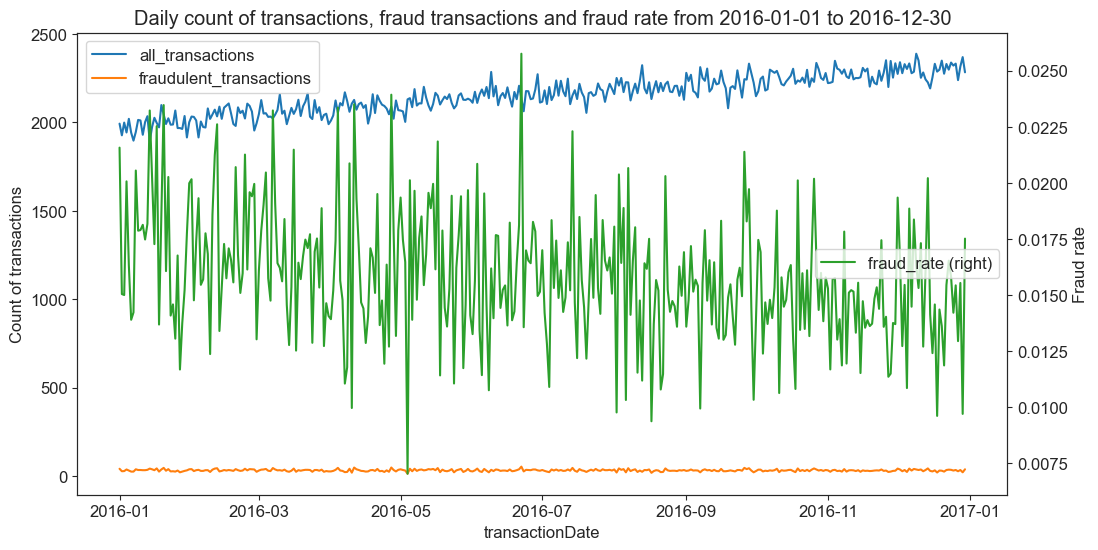

In [66]:
temp = df[['transactionDateTime', 'isFraud']].copy(deep=True)
temp["transactionDate"] = pd.to_datetime(temp["transactionDateTime"]).dt.date
ax = temp.groupby("transactionDate").agg(all_transactions=("isFraud", "size"), 
                                    fraudulent_transactions=("isFraud", "sum"),
                                    ).plot()
temp.groupby("transactionDate").agg(fraud_rate=("isFraud", "mean")).plot(secondary_y=True, ax=ax)

ax.set_ylabel('Count of transactions')
ax.right_ax.set_ylabel('Fraud rate')

h1, l1 = ax.get_legend_handles_labels()
ax.legend(h1, l1, loc=2)
h2, l2 = ax.right_ax.get_legend_handles_labels()
ax.right_ax.legend(h2, l2, loc=5)

plt.title("Daily count of transactions, fraud transactions and fraud rate from 2016-01-01 to 2016-12-30")
plt.show()

## 4.3 Numerical Features

- creditLimit - most of the credit card holders have their credit limit less than 20k  
- availableMoney - most of the credit card holders have less than 10k available balance. NOTE: Some transaction will go beyond the credit limit, hence making he available money negative. But it won't make a difference in the fraud rate.  
- transactionAmount - people usually use credit cards for small purchases ~500.
- currentBalance - most of the credit card holders have less than 10k balance currently.

1. Let's first demonstrate the distributions of the numerical features in the as-is dataset by fraud or not.
2. Let's then show the distributions of the numerical features after the preliminary feature engineering.

### 4.3.1 As-is dataset numerical features
Via the grouped violin plots, we can see that the fraudulent transactions have a wider range of 'transactionAmount' and 'availableMoney' than the non-fraudulent transactions. The 'currentBalance' of the fraudulent transactions is more concentrated around 0 than the non-fraudulent transactions.

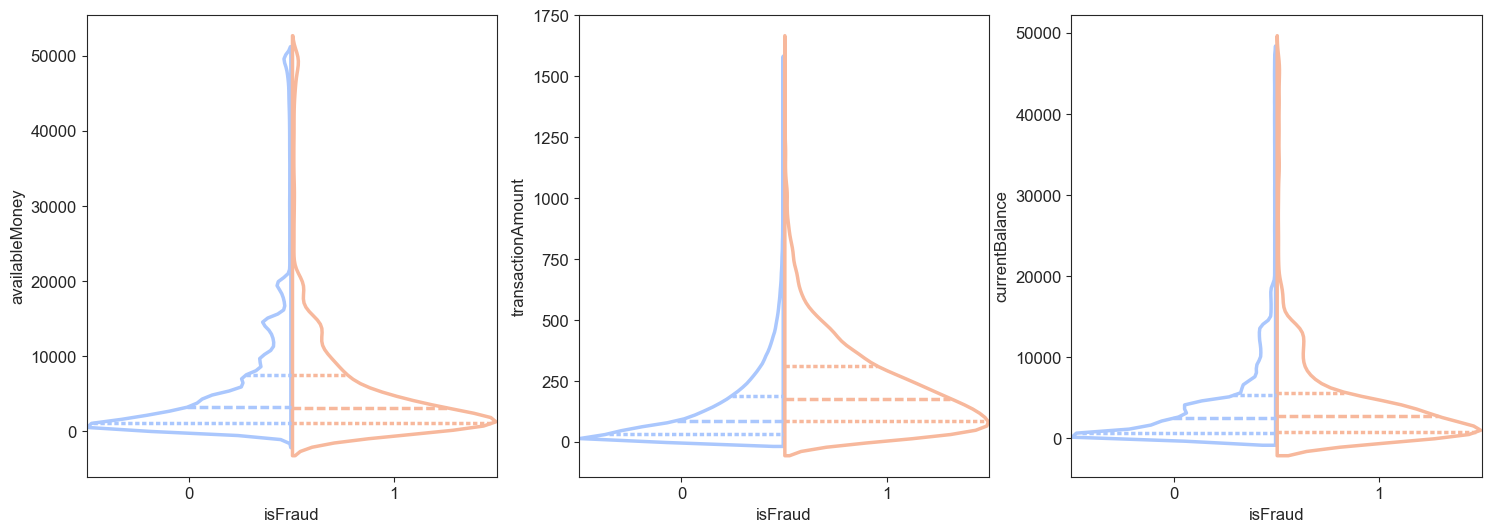

In [67]:
## 4.3.1 Numerical Features in the as-is dataset
# Violin plot of the x_num_y numerical features grouped by the label column, and use the gap parameter to make the violins' verticle lines overlap
x_num_original_y = pd.concat([x_num_original, y], axis=1)
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.violinplot(x='isFraud', y='availableMoney', data=x_num_original_y, ax=ax[0], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, density_norm='area', gap=-0.24)
ax[0].set_ylabel('availableMoney')
sns.violinplot(x='isFraud', y='transactionAmount', data=x_num_original_y, ax=ax[1], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, density_norm='area', gap=-0.24)
ax[1].set_ylabel('transactionAmount')
sns.violinplot(x='isFraud', y='currentBalance', data=x_num_original_y, ax=ax[2], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, density_norm='area', gap=-0.24)
ax[2].set_ylabel('currentBalance')
plt.show()

In addition, we can replot the positive part of the above as-is numerical features' violin plots in log scale to see their distributions more clearly.

In [68]:
df['transactionAmount'].isna().sum()

0

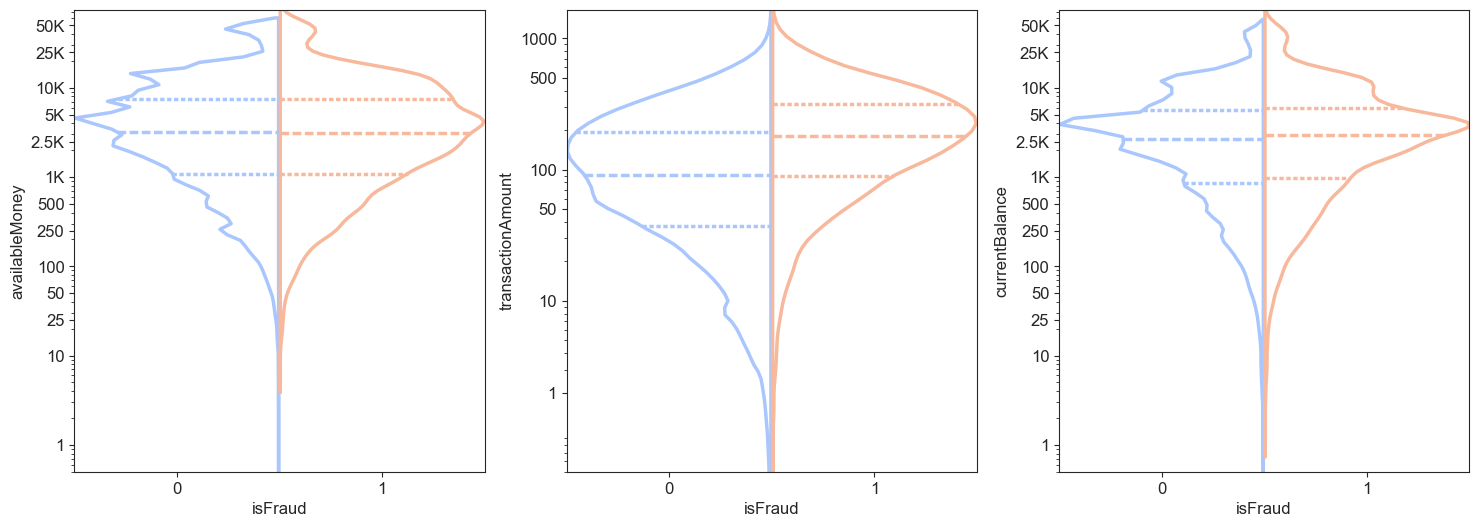

In [69]:
# Violin plot of the log-transformed positive portion numerical features by the label column
x_num_log = x_num_original.copy()
x_num_log.loc[x_num_log['availableMoney'] <=0, 'availableMoney'] = np.nan
x_num_log.loc[x_num_log['transactionAmount'] <=0, 'transactionAmount'] = np.nan
x_num_log.loc[x_num_log['currentBalance'] <=0, 'currentBalance'] = np.nan
# hstack x_xum_bc with y
x_num_log_y = pd.concat([x_num_log, y], axis=1)
# Violin plot of the log-transformed numerical features by the label column, change the y label to log(creditLimit), log(transactionAmount), and log(availableMoney)
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.violinplot(x='isFraud', y='availableMoney', data=x_num_log_y, ax=ax[0], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=True)
ax[0].set_ylabel('availableMoney')
ax[0].set_yticks([1, 10,25,50,100,250, 500, 10**3, 2500, 5000, 10**4, 25000, 50000])
ax[0].set_yticklabels(['1','10','25','50','100','250', '500', '1K', '2.5K', '5K',  '10K', '25K', '50K'])
ax[0].set_ylim(0.5, 75000)
sns.violinplot(x='isFraud', y='transactionAmount', data=x_num_log_y, ax=ax[1], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=True)
ax[1].set_ylabel('transactionAmount')
ax[1].set_yticks([2, 10, 50, 100, 500, 1000])
ax[1].set_yticklabels([ '1', '10', '50', '100', '500', '1000'])
ax[1]. set_ylim(.5, 1650)
sns.violinplot(x='isFraud', y='currentBalance', data=x_num_log_y, ax=ax[2], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=True)
ax[2].set_ylabel('currentBalance')
ax[2].set_yticks([1, 10,25,50,100,250, 500, 10**3, 2500, 5000, 10**4, 25000, 50000])
ax[2].set_yticklabels(['1','10','25','50','100','250', '500', '1K', '2.5K', '5K',  '10K', '25K', '50K'])
ax[2].set_ylim(0.5, 75000)
plt.show()

The statistics of the as-is numerical features are as follows:

In [70]:
x_num_original.describe()

,availableMoney,transactionAmount,currentBalance
count,786352.000000,786352.000000,786352.000000
mean,6250.676007,136.962760,4508.762832
std,8880.691639,147.597735,6457.474126
min,-1005.630000,0.000000,0.000000
25%,1077.420000,33.650000,689.910000
50%,3184.855000,87.900000,2451.775000
75%,7500.000000,191.472500,5291.102500
max,50000.000000,1608.350000,47498.810000


### 4.3.2 Post feature preprocessing numerical features

- Since the currentBalance is just the creditLimit minus the availableMoney, they are highly linearly correlated by definition. So, we might not toss all of them into the models. Instead, two out of the three might be sufficient.
- Also, let us use a new column ['creditUtilizationRate'] as the ratio of ['currentBalance'] with respect to ['creditLimit'] to replace the ['currentBalance'] column. 
- Similarly, we use a new column ['availableMoneyRate'] as the ratio of ['availableMoney'] with respect to ['creditLimit'] to replace the ['currentBalance'] column. 
- In addition, we have the columns ['d_since_open', 'd_since_update_add', 'd_2_exp'] in integer days defined during the feature preprocessing. 
- Finally, we normalize the numerical features by the MinMaxScaler. Then violin plot the normalized numerical features grouped by the label column.

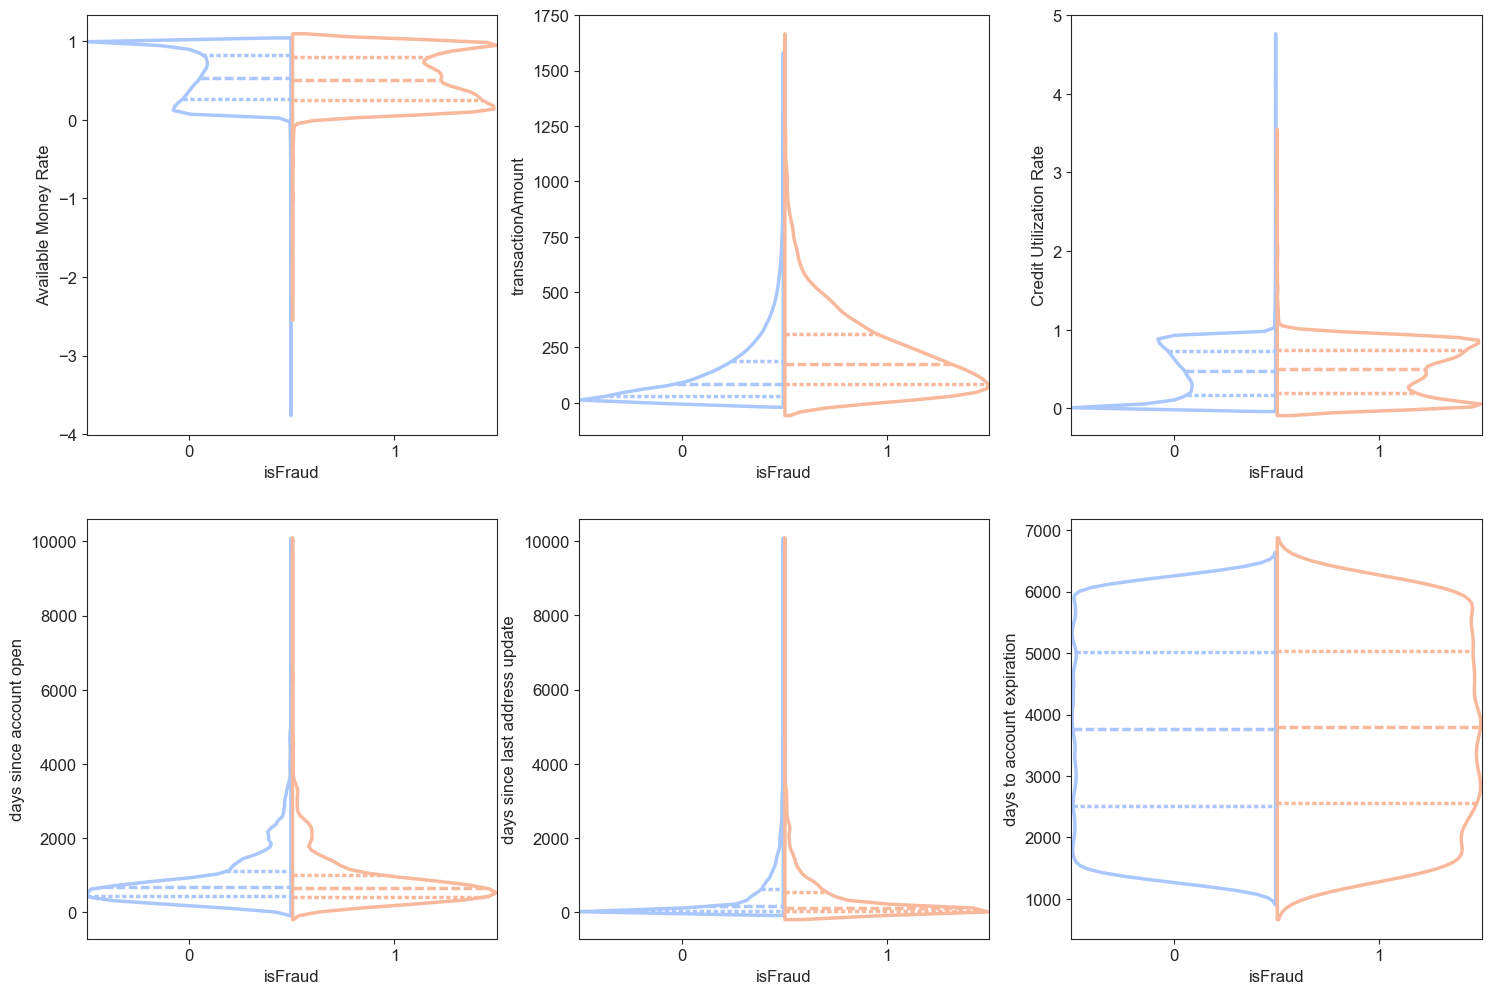

In [71]:
# Violin plot of the post preprocessing numerical features by the label column 'isFraud'
fig, ax = plt.subplots(2,3, figsize=(18,12))
sns.violinplot(x='isFraud', y='availableMoneyRate', data=df, ax=ax[0,0], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=False)
ax[0,0].set_ylabel('Available Money Rate')
sns.violinplot(x='isFraud', y='transactionAmount', data=df, ax=ax[0,1], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=False)
ax[0,1].set_ylabel('transactionAmount')
sns.violinplot(x='isFraud', y='creditUtilizationRate', data=df, ax=ax[0,2], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24, log_scale=False)
ax[0,2].set_ylabel('Credit Utilization Rate')
sns.violinplot(x='isFraud', y='d_since_open', data=df, ax=ax[1,0], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24)
ax[1,0].set_ylabel('days since account open')
sns.violinplot(x='isFraud', y='d_since_update_add', data=df, ax=ax[1,1], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24)
ax[1,1].set_ylabel('days since last address update')
sns.violinplot(x='isFraud', y='d_2_exp', data=df, ax=ax[1,2], hue='isFraud', palette='coolwarm', split=True, inner='quartile', legend=False, fill=False, linewidth=2.5, gap=-0.24)
ax[1,2].set_ylabel('days to account expiration')
plt.show()

It is evident from the above plots that the ['availableMoneyRate', 'transactionAmount', creditUtilizationRate', 'd_since_update_add'] show informative discrepancies in their respective grouped distributions, whereas the ['d_since_open', 'd_2_exp'] columns are more or less the same across the two groups.

We can also see from the below statistics on the normalized numerical features that ['availableMoenyRate'] and ['creditUtilizationRate'] are as informative as the ['availableMoney'] and ['currentBalance'] columns in the as-is dataset, but the bulk of this data is already within the[0, 1] range, which is favored by many machine learning algorithms. Then, we just need to scale the ['transactionAmount', 'd_since_open', 'd_since_update_add', 'd_2_exp'] column to the [0, 1] range as well via the MinMaxSacalar. 

In [72]:
scaler = MinMaxScaler()
df['transactionAmount_norm'] = scaler.fit_transform(df[['transactionAmount']])
df['d_since_open_norm'] = scaler.fit_transform(df[['d_since_open']])
df['d_since_update_add_norm'] = scaler.fit_transform(df[['d_since_update_add']])
df['d_2_exp_norm'] = scaler.fit_transform(df[['d_2_exp']])
# save the preprocessed data to a new dataframe, and describe them
x_num_norm_columns = ['transactionAmount_norm', 'availableMoneyRate', 'creditUtilizationRate', 'd_since_open_norm', 'd_since_update_add_norm', 'd_2_exp_norm']
x_num_norm = df[x_num_norm_columns]
x_num_norm.describe()

,transactionAmount_norm,availableMoneyRate,creditUtilizationRate,d_since_open_norm,d_since_update_add_norm,d_2_exp_norm
count,786352.000000,786352.000000,786352.000000,786352.000000,786352.000000,786352.000000
mean,0.085157,0.539581,0.460419,0.088350,0.044875,0.498109
std,0.091770,0.308667,0.308667,0.069827,0.066436,0.270022
min,0.000000,-3.722200,0.000000,0.000000,0.000000,0.000000
25%,0.020922,0.268794,0.172859,0.042947,0.002803,0.264750
50%,0.054652,0.527025,0.472975,0.067975,0.015916,0.498880
75%,0.119049,0.827141,0.731206,0.110822,0.061261,0.731329
max,1.000000,1.000000,4.722200,1.000000,1.000000,1.000000


## 4.4 Categorical Features
Let's break down the analsis into 4 sub-blocks,  the transaction oriented features ['transactionType', 'posEntryMode', 'posConditionCode',  'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV'], the account oriented features ['accountNumber', 'cardLast4Digits', 'creditLimit', 'acqCountry'], the merchant oriented features ['merchantName', 'merchantCountryCode', 'merchantCategoryCode'], and the time oriented features ['transactionDateTime', 'x_hr', 'x_d', 'x_DOW', 'x_mon'].

In [73]:
def plot_cate_by_label_rate(fea, df, rotate=30, order_use=None, hue_label='isFraud', title=None, fontsize=8):
    if order_use is None:
        order_use = df[fea].value_counts(ascending=False).index
    
    ax = sns.countplot(x=fea, data=df, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
    abs_values = df[fea].value_counts(ascending=False)
    rel_values = df.groupby(fea)['isFraud'].mean().loc[df[fea].value_counts(ascending=False).index]
    lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
    for label in ax.get_xticklabels():
        label.set_rotation(rotate)
    if title is not None:
        ax.set_title(title)
    if any(lbls) is not None:
        ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=fontsize)
    ax.set_ylabel('Count')
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=fontsize)
    plt.show()

### 4.4.1 Transaction oriented features analysis, ['transactionType', 'posEntryMode', 'posConditionCode',  'cardPresent', 'expirationDateKeyInMatch'].


The transaction oriented features have very low cardinalities. We could use the bar plots to show the distributions of the categorical features by the label column.

In [74]:
x_cat[['transactionType', 'posEntryMode', 'posConditionCode',  'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV']].nunique()

transactionType             4
posEntryMode                6
posConditionCode            4
cardPresent                 2
expirationDateKeyInMatch    2
mismatchInCVV               4
dtype: int64

#### 4.4.1.1 transactionType
It originally contains 3 types, 'purchase', 'reversal', and 'address_verification'. We then label the missing ones as new type 'unknown'. The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. To our amaze, we find the 'address_verification' transactions' fraud rate are 60% less than the average, whereas the 'Unknown' transactions' fraud rate is 25% higher than the average. The 'purchase' and 'reversal' transactions' fraud rate are on par with the average.
- Q: What are the typical transaction types for the fraudulent transactions?
- A: The fraudulent transactions are mostly 'PURCHASE' and 'ADDRESS_VERIFICATION'.

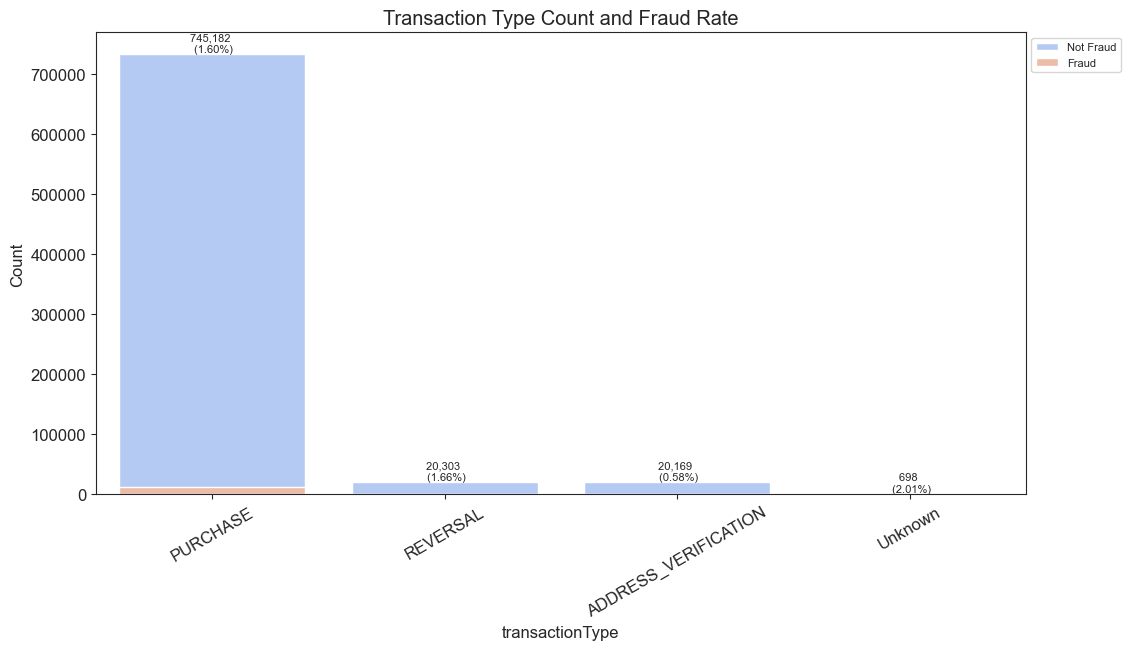

In [75]:
# Bar plots of the 'transactionType' grouped by the label column
fea = 'transactionType'
plot_cate_by_label_rate(fea, x_cat_y, rotate=30, title='Transaction Type Count and Fraud Rate')

#### 4.4.1.2 posEntryMode
posEntryMode - It is the two-digit code identifies the actual method used to enter the cardholder account number and card expiration date originally contains 5 types:

- 02 -- Magnetic stripe,
- 05 -- Card chip/IC read,
- 09 -- Electronic commerce,
- 80 -- Faulty chip/IC read, fallback to stripe, 
- 90 -- Magnetic stripe with CVV (sub to 02).

We then label the missing ones as new type 'unknown'. The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find the '05-Chip' fraud rate is 50% below the average fraud rate level, whereas the 'Unknown' transactions' fraud rate is 300% higher and '09-Ecommerce' transactions' fraud rate is 70% higher than the average.

(Ref: https://developer.network.ae/docs/read/upf/appendix/POS_Entry_Mode)

In [76]:
# change the type of the 'posEntryMode' column by adding meaningful labels list above
# change '02' to '02-Magstripe', '05' to '05-Chip', '09' to '09-Ecommerce', '80' to '80-ChipFallbackMagstrip', '90' to '90-MagtripW/CVV'
x_cat_y['posEntryMode'] = x_cat_y['posEntryMode'].replace({'02':'02-Magstripe', '05':'05-Chip', '09':'09-Ecommerce', '80':'80-ChipFallbackMagstrip', '90':'90-MagtripW/CVV'})
x_cat['posEntryMode'] = x_cat['posEntryMode'].replace({'02':'02-Magstripe', '05':'05-Chip', '09':'09-Ecommerce', '80':'80-ChipFallbackMagstrip', '90':'90-MagtripW/CVV'})
df['posEntryMode'] = df['posEntryMode'].replace({'02':'02-Magstripe', '05':'05-Chip', '09':'09-Ecommerce', '80':'80-ChipFallbackMagstrip', '90':'90-MagtripW/CVV'})
# Bar plots of the 'posEntryMode' grouped by the label column
fea = 'posEntryMode'

#### 4.4.1.3 posConditionCode

posConditionCode - It is a code identifying transaction conditions at the point-of-sale or point-of-service

- 01 -- Cardholder unpresent,
- 08 -- Mail/Phone order,
- 99 -- No information.

We then label the missing ones as new type 'unknown'. The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find the '08-Mail/PhoneOrder' fraud rate is 20% below the average fraud rate level, whereas the 'Unknown' transactions' fraud rate is 240% higher and '99' transactions' fraud rate is 90% higher than the average.
 (Ref: https://www.mreports.com/documentation/ac/nonmerchant/80449.htm)

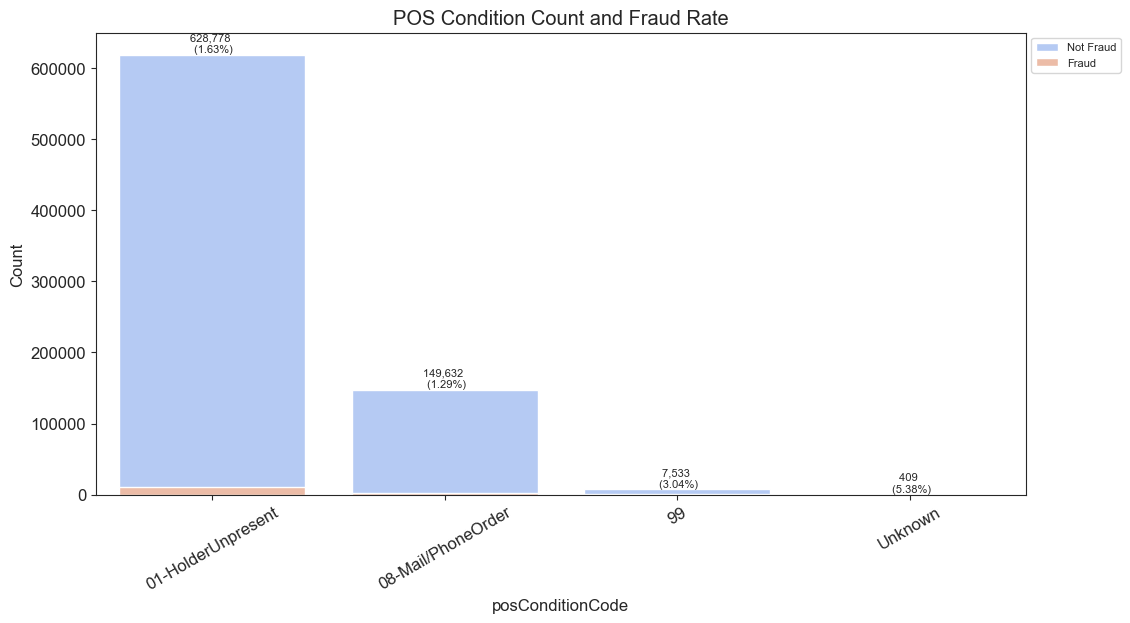

In [77]:
# change the type of the 'posConditionCode' column by adding meaningful labels list above
# change '01' to '01-HolderUnpresent', '08' to '08-Mail/PhoneOrder'
x_cat['posConditionCode'] = x_cat['posConditionCode'].replace({'01':'01-HolderUnpresent', '08':'08-Mail/PhoneOrder'})
x_cat_y['posConditionCode'] = x_cat_y['posConditionCode'].replace({'01':'01-HolderUnpresent', '08':'08-Mail/PhoneOrder'})
df['posConditionCode'] = df['posConditionCode'].replace({'01':'01-HolderUnpresent', '08':'08-Mail/PhoneOrder'})
# Bar plots of the 'posConditionCode' grouped by the label column
fea = 'posConditionCode'

plot_cate_by_label_rate(fea, x_cat_y, rotate=30, title='POS Condition Count and Fraud Rate')

#### 4.4.1.4 cardPresent

The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find when card is present, the fraud rate is 40% below the average fraud rate level, whereas the fraud rate is 25% higher than the average when card is not present.

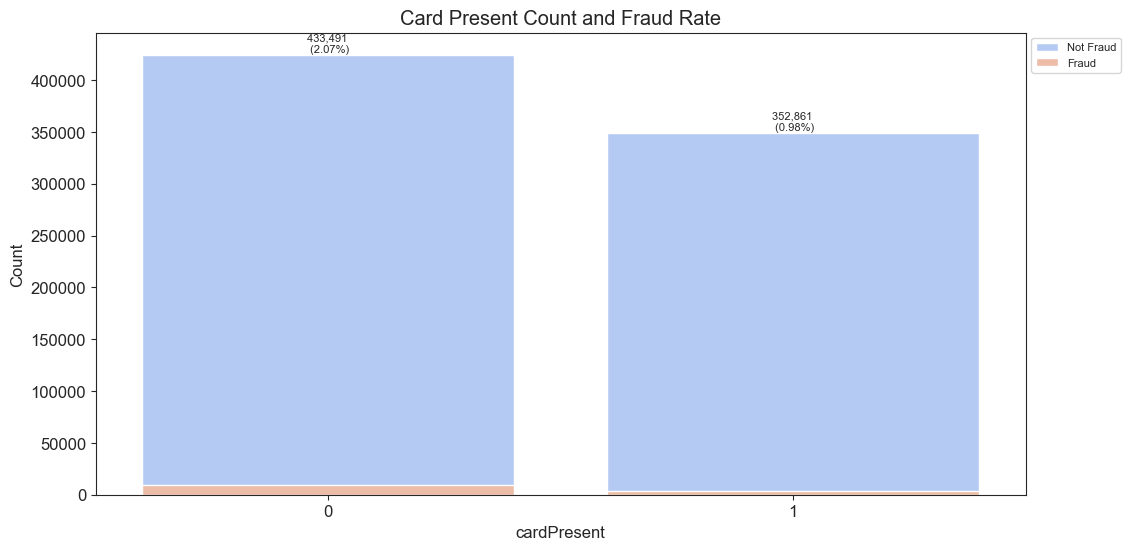

In [78]:
# Bar plots of the 'cardPresent' grouped by the label column
fea = 'cardPresent'
plot_cate_by_label_rate(fea, x_cat_y, rotate=0, title='Card Present Count and Fraud Rate')

#### 4.4.1.5 expirationDateKeyInMatch
The term "expirationdatekeyinmatch" typically refers to a situation where a system or software prompts a user to input or match an expiration date for verification or authentication purposes. It could be part of a security protocol where a user is required to enter a specific expiration date associated with a card, document, or other credential to confirm its validity or access rights. This term is commonly used in contexts such as payment processing, access control systems, or any situation where validating the expiration of a document or credential is necessary.
The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find when match is prompted, the fraud rate is 20% below the average fraud rate level, whereas the fraud rate remains unchanged when the match is not prompted.

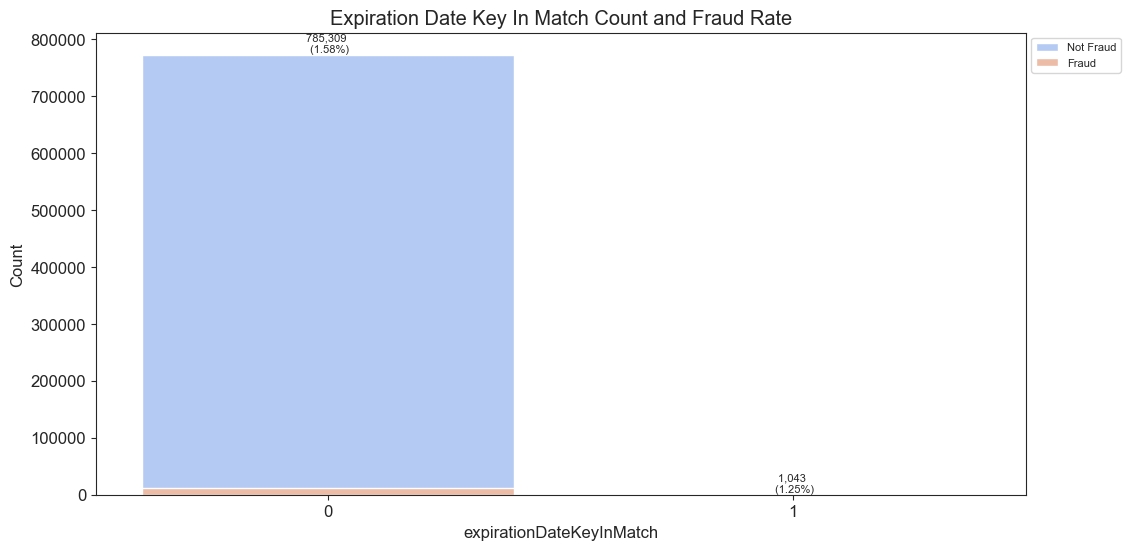

In [79]:
# Convert 'expirationDateKeyInMatch' column to string type
x_cat_y['expirationDateKeyInMatch'] = x_cat_y['expirationDateKeyInMatch'].astype(str)
x_cat['expirationDateKeyInMatch'] = x_cat['expirationDateKeyInMatch'].astype(str)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(str)


# Bar plots of the 'expirationDateKeyInMatch' grouped by the label column
fea = 'expirationDateKeyInMatch'
plot_cate_by_label_rate(fea, x_cat_y, rotate=0, title='Expiration Date Key In Match Count and Fraud Rate')

#### 4.4.1.6 mismatchInCVV
We coalesce the information contained in ['cardCVV', 'enteredCVV'] columns to a new categorical ['mismatchInCVV'] column showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns. And we discover that different counts of mismatch actually correspond to different levels in fraud rates, albeit they are all higher than normal. It is interesting to see that there are few examples where the entered CVV doesn't match the card CVV but the transaction still marked as non-fraudulent. There esists several scenarios where there can be a legit non-matching cvv transaction such as recurring/reversal payments. For example, once the initial setup is done, it doesn't require a match CVV if the account's historical data like users' spending pattern, location, verified merchantName match the records on file.

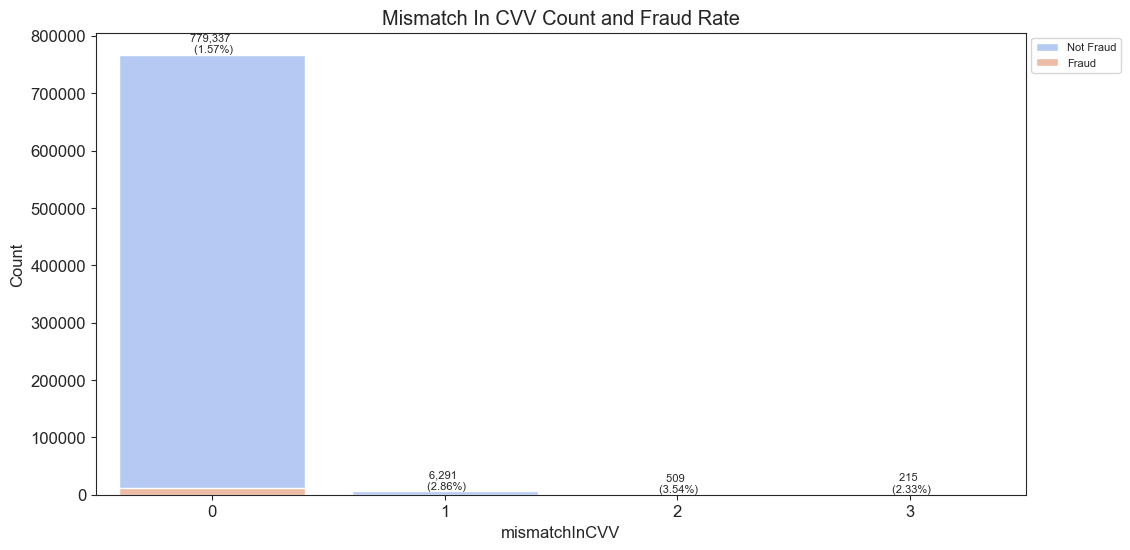

In [80]:
# Bar plots of the 'mismatchInCVV' grouped by the label column in the order of value [0,1,2,3] of the 'mismatchInCVV'
fea = 'mismatchInCVV'
desired_order = ['0', '1', '2', '3']
plot_cate_by_label_rate(fea, x_cat_y, rotate=0, order_use=desired_order, title='Mismatch In CVV Count and Fraud Rate')

### 4.4.2 Account oriented features analysis, ['accountNumber', 'cardLast4Digits', 'creditLimit', 'acqCountry']. 
The account oriented features have high cardinalities in the accountNumber and cardLast4Digits, we will use histograms and tables to demonstrate their distributions. In addition, We could use the bar plots to show the distributions of the rest categorical features creditLimit and acqCountry.

In [81]:
x_cat[['accountNumber', 'cardLast4Digits', 'creditLimit', 'acqCountry']].nunique()

accountNumber      5000
cardLast4Digits    5246
creditLimit          10
acqCountry            4
dtype: int64

#### 4.4.2.1 accountNumber

We first verify that each account has 1 and only 1 creditLimit.

In [82]:
res = df[['creditLimit', 'accountNumber']].groupby('accountNumber').agg(pd.Series.mode).reset_index()
# select the accountNumber with multiple creditLimits
res[res.duplicated()]

,accountNumber,creditLimit


Secondly, check the fraud transaction count and fraud percentage in all transaction by the accountNumber 

In [83]:
# get the fraud transaction count by the accountNumber 
fraud_by_acct = df[['accountNumber', 'isFraud']].groupby('accountNumber').agg('sum')
# get the total transaction count by the accountNumber
trans_by_acct = df['accountNumber'].value_counts()
# compute the fraud transaction percentage with respect to the total transaction per accountNumber
fraud_perc_by_acct = fraud_by_acct.merge(trans_by_acct, on ='accountNumber', how='inner')
fraud_perc_by_acct['fraudPercentage'] = fraud_perc_by_acct['isFraud']/fraud_perc_by_acct['count']
a, b = fraud_perc_by_acct[fraud_perc_by_acct['isFraud']!=0].shape[0], fraud_perc_by_acct[fraud_perc_by_acct['isFraud']==0].shape[0]
print(f'The number of accountNumbers involved in fraudulent transactions is {a}.')
print(f'The number of accountNumbers NOT involved in fraudulent transactions is {b}.')

The number of accountNumbers involved in fraudulent transactions is 2075.
The number of accountNumbers NOT involved in fraudulent transactions is 2925.


In [84]:
# the top 10 accountNumber with the highest total transaction counts
fraud_perc_by_acct.sort_values(by='count',ascending=False).head(10)

,isFraud,count,fraudPercentage
accountNumber,,,
380680241,783,32850,0.023836
882815134,97,13189,0.007355
570884863,59,10867,0.005429
246251253,278,10172,0.027330
369308035,136,7229,0.018813
724518977,64,6283,0.010186
894938833,44,6101,0.007212
419709514,207,5930,0.034907
832842201,75,5850,0.012821


In [85]:
# the top 10 accountNumber with the highest fraudulent transaction counts
fraud_perc_by_acct.sort_values(by='isFraud',ascending=False).head(10)

,isFraud,count,fraudPercentage
accountNumber,,,
380680241,783,32850,0.023836
782081187,307,2435,0.126078
246251253,278,10172,0.027330
700725639,272,3313,0.082101
472288969,266,1790,0.148603
208319653,211,5235,0.040306
419709514,207,5930,0.034907
369308035,136,7229,0.018813
794398270,135,1810,0.074586


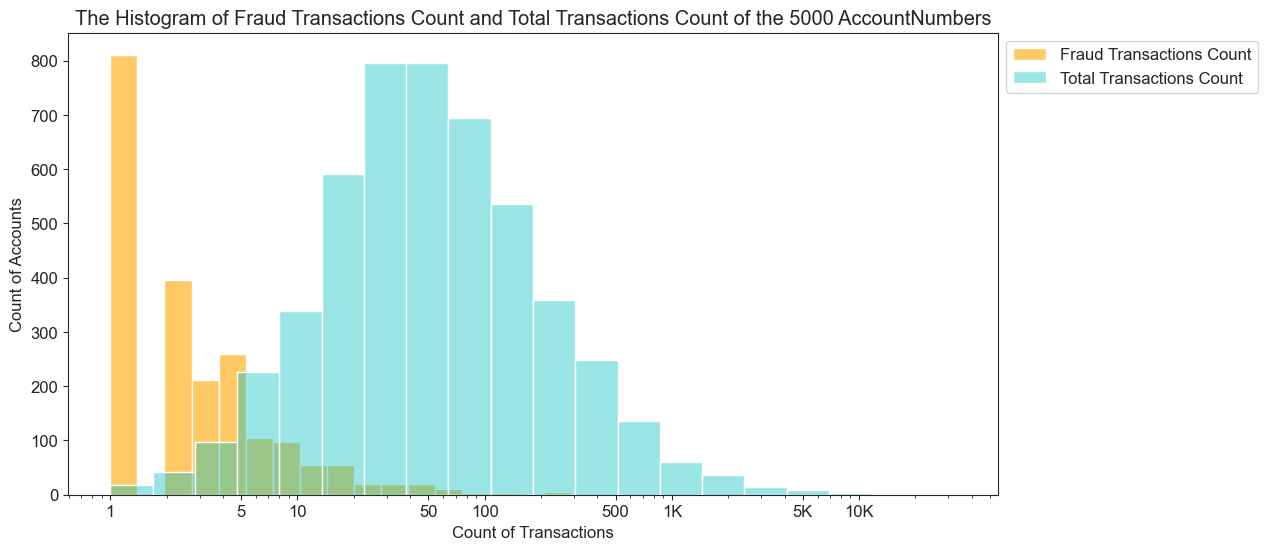

In [86]:
# plot the histogram of isFraud and the histogram of count in the dataframe fraud_perc_by_acct
sns.histplot(fraud_perc_by_acct['isFraud'], bins=20, color='orange',  log_scale=True, label='Fraud Transactions Count', alpha=0.6)
sns.histplot(fraud_perc_by_acct['count'], bins=20, color='c',  log_scale=True, label='Total Transactions Count', alpha=0.4)
plt.title('The Histogram of Fraud Transactions Count and Total Transactions Count of the 5000 AccountNumbers')
plt.xlabel('Count of Transactions')
plt.ylabel('Count of Accounts')
plt.xticks([1, 5, 10, 50, 100, 500, 1000, 5000, 10000], labels= ['1', '5', '10', '50', '100', '500', '1K', '5K', '10K'])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [87]:
# the top 10 percentage of the fraudulent transactions in the total transactions counts per accountNumber
fraud_perc_by_acct.sort_values(by='fraudPercentage',ascending=False).head(10)

,isFraud,count,fraudPercentage
accountNumber,,,
749645399,1,1,1.000000
356886744,2,2,1.000000
494400203,2,4,0.500000
666461201,1,2,0.500000
275266909,1,3,0.333333
938195288,35,114,0.307018
319012201,2,7,0.285714
336236533,5,18,0.277778
838703913,58,212,0.273585


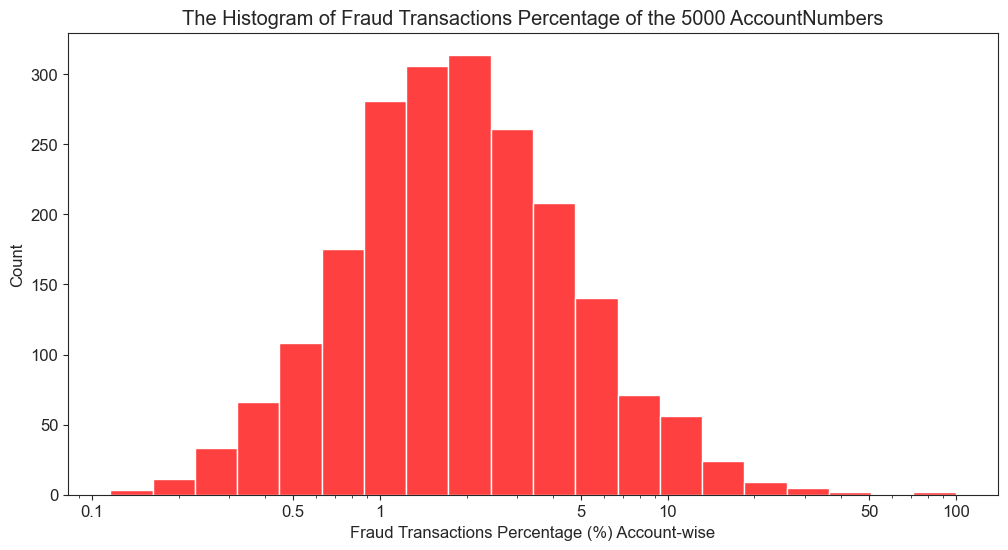

In [88]:
# plot the histogram of the fraudPercentage in the dataframe fraud_perc_by_acct
sns.histplot(fraud_perc_by_acct['fraudPercentage'], bins=20, color='red',  log_scale=True)
plt.title('The Histogram of Fraud Transactions Percentage of the 5000 AccountNumbers')
plt.xlabel('Fraud Transactions Percentage (%) Account-wise')
plt.xticks([0.001, 0.005, 0.01, 0.05,  0.1, 0.5, 1], labels= ['0.1', '0.5', '1', '5', '10', '50', '100'])
plt.show()

Thirdly, check the fraud amount and fraud amount percentage in all transaction by the accountNumber. 

In [89]:
# get the fraud transaction amount by the accountNumber 
a = df[df['isFraud']==1].groupby('accountNumber')[['transactionAmount']].agg('sum')
# get the total transaction amount by the accountNumber
b = df.groupby('accountNumber')[['transactionAmount']].agg('sum')
# compute the fraud transaction amount percentage with respect to the total transaction amount per accountNumber
fraud_amount_perc_by_acct = a.merge(b, on ='accountNumber', how='right', suffixes=('_fraud', "_total")).fillna(0)
fraud_amount_perc_by_acct['fraudAmountPercentage'] = fraud_amount_perc_by_acct['transactionAmount_fraud']/fraud_amount_perc_by_acct['transactionAmount_total']
# calculate the overall fraud transaction amount and the overall transaction amount across all accounts
a, b = fraud_amount_perc_by_acct['transactionAmount_fraud'].sum(), fraud_amount_perc_by_acct['transactionAmount_total'].sum()
c = fraud_amount_perc_by_acct['fraudAmountPercentage'].mean()
print(f'The overall fraud-involved transaction amount across all accounts is ${a:,}.')
print(f'The overall transaction amount across all accounts is ${b:,}.')
print(f'The average fraud-involved transaction amount percentage across all accounts is {c:.2%}.')

The overall fraud-involved transaction amount across all accounts is $2,796,505.89.
The overall transaction amount across all accounts is $107,700,940.44.
The average fraud-involved transaction amount percentage across all accounts is 2.15%.


In [90]:
fraud_amount_perc_by_acct.describe()

,transactionAmount_fraud,transactionAmount_total,fraudAmountPercentage
count,5000.000000,5.000000e+03,4999.000000
mean,559.301178,2.154019e+04,0.021521
std,3601.540740,9.517081e+04,0.055330
min,0.000000,0.000000e+00,0.000000
25%,0.000000,1.916815e+03,0.000000
50%,0.000000,5.584950e+03,0.000000
75%,360.515000,1.622263e+04,0.022667
max,200599.190000,4.765004e+06,1.000000


In [91]:
# the top 10 account with the most fraudulent transactions in dollar values
fraud_amount_perc_by_acct.sort_values(by='transactionAmount_fraud',ascending=False).head(10)

,transactionAmount_fraud,transactionAmount_total,fraudAmountPercentage
accountNumber,,,
380680241,200599.19,4765004.34,0.042098
419709514,52433.58,876339.20,0.059833
700725639,49950.15,482117.25,0.103606
782081187,47907.74,351897.61,0.136141
472288969,44764.62,266297.35,0.168100
246251253,44250.04,1476262.36,0.029974
208319653,41284.88,763421.90,0.054079
369308035,31621.20,1055003.36,0.029973
269616174,26960.58,524551.29,0.051397


In [92]:
# the top 10 account with the most transactions in dollar values
fraud_amount_perc_by_acct.sort_values(by='transactionAmount_total',ascending=False).head(10)

,transactionAmount_fraud,transactionAmount_total,fraudAmountPercentage
accountNumber,,,
380680241,200599.19,4765004.34,0.042098
882815134,24276.52,1917310.66,0.012662
570884863,16578.68,1569178.94,0.010565
246251253,44250.04,1476262.36,0.029974
369308035,31621.20,1055003.36,0.029973
724518977,16736.18,912909.46,0.018333
894938833,13173.64,894104.42,0.014734
419709514,52433.58,876339.20,0.059833
832842201,19655.99,866737.20,0.022678


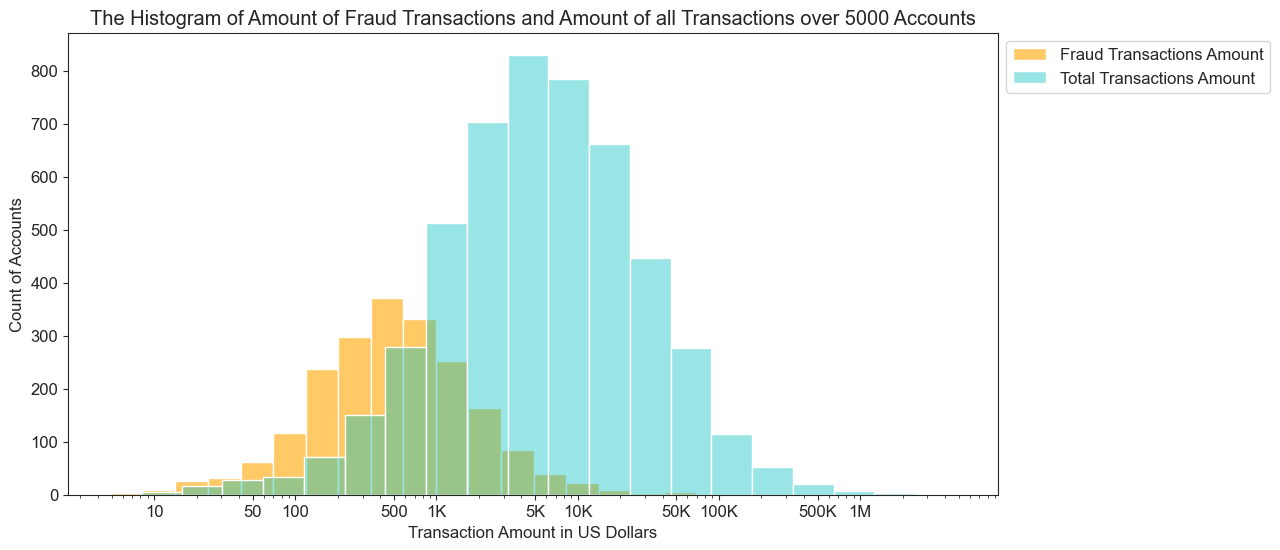

In [93]:
# plot the histogram of fraud transaction amount and the histogram of total transaction amount in the dataframe fraud_amount_perc_by_acct
sns.histplot(fraud_amount_perc_by_acct['transactionAmount_fraud'], bins=20, color='orange',  log_scale=True, label='Fraud Transactions Amount', alpha=0.6)
sns.histplot(fraud_amount_perc_by_acct['transactionAmount_total'], bins=20, color='c',  log_scale=True, label='Total Transactions Amount', alpha=0.4)
plt.xticks([10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000], labels= ['10', '50', '100', '500', '1K', '5K', '10K', '50K', '100K', '500K', '1M'])
plt.title('The Histogram of Amount of Fraud Transactions and Amount of all Transactions over 5000 Accounts')
plt.xlabel('Transaction Amount in US Dollars')
plt.ylabel('Count of Accounts')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [94]:
# the top 10 account with the highest fraud amount percentage
fraud_amount_perc_by_acct.sort_values(by='fraudAmountPercentage',ascending=False).head(10)

,transactionAmount_fraud,transactionAmount_total,fraudAmountPercentage
accountNumber,,,
749645399,523.99,523.99,1.000000
356886744,337.74,337.74,1.000000
666461201,395.31,403.30,0.980188
630456222,701.84,872.35,0.804539
135357269,161.47,218.02,0.740620
494400203,310.14,511.00,0.606928
871308138,986.37,1761.30,0.560024
632453546,121.38,224.95,0.539587
396249447,440.25,832.84,0.528613


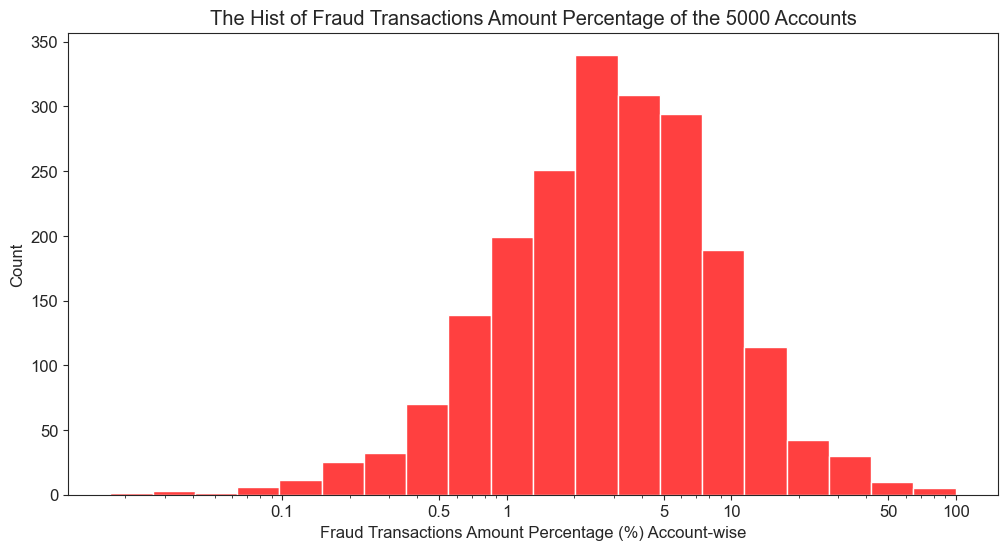

In [95]:
# plot the histogram of the fraudAmountPercentage in the dataframe fraud_amount_perc_by_acct
sns.histplot(fraud_amount_perc_by_acct['fraudAmountPercentage'], bins=20, color='red',  log_scale=True)
plt.title('The Hist of Fraud Transactions Amount Percentage of the 5000 Accounts')
plt.xlabel('Fraud Transactions Amount Percentage (%) Account-wise')
plt.xticks([0.001, 0.005, 0.01, 0.05,  0.1, 0.5, 1], labels= ['0.1', '0.5', '1', '5', '10', '50', '100'])
plt.show()

#### 4.4.2.2 cardLast4Digits
- Some account have multiple cardLast4Digits, perhaps one unique cardLast4Digits corresponds one primary/authorized user.
- 1 account has 6 users.
- 7 accounts have 5 users.
- 45 accounts have 4 users.
- 369 accounts have 3 users.
- 1474 accounts have 2 users.
- 3104 accounts have only 1 user.
- 5000 accounts have 7380 users in total. 
- **Not all cardLast4Digits have 4 digits, we fill pad those with leading zeros in prior.** 
- Moreover, we observed the fraud rates are not equal when one account number ensued by different last 4 digits. We suspect that this correlates to different credit card using scenarios imposed by different users.
- Conclusion: We would replace the original 'accountNumber' + 'cardLast4Digits' features by a combined feature 'accountNumber+4Digits' for a finer granularity of our analysis.

In [96]:
a = x_cat_y[['accountNumber', 'cardLast4Digits']].groupby(['accountNumber'])['cardLast4Digits'].nunique().reset_index()
# store the list of accountNumbers with the number of 6, 5, 4, 3, 2, 1 unique cardLast4Digits
acct_6_checkdigits = a[a['cardLast4Digits']==6]['accountNumber']
acct_5_checkdigits = a[a['cardLast4Digits']==5]['accountNumber']
acct_4_checkdigits = a[a['cardLast4Digits']==4]['accountNumber']
acct_3_checkdigits = a[a['cardLast4Digits']==3]['accountNumber']
acct_2_checkdigits = a[a['cardLast4Digits']==2]['accountNumber']
acct_1_checkdigits = a[a['cardLast4Digits']==1]['accountNumber']
# get the total count of card holders with the number of 6, 5, 4, 3, 2, 1 unique cardLast4Digits
count_of_cards = 6*acct_6_checkdigits.shape[0] + 5*acct_5_checkdigits.shape[0] + 4*acct_4_checkdigits.shape[0] + 3*acct_3_checkdigits.shape[0] + 2*acct_2_checkdigits.shape[0] + 1*acct_1_checkdigits.shape[0]
# print the count of accountNumbers with the number of 6, 5, 4, 3, 2, 1 unique cardLast4Digits
print(f'The count of accountNumbers with six cards of cardLast4Digits is {len(acct_6_checkdigits)}.')
print(f'The count of accountNumbers with five cards of cardLast4Digits is {len(acct_5_checkdigits)}.')
print(f'The count of accountNumbers with four cards of cardLast4Digits is {len(acct_4_checkdigits)}.')
print(f'The count of accountNumbers with three cards of cardLast4Digits is {len(acct_3_checkdigits)}.')
print(f'The count of accountNumbers with two cards of cardLast4Digits is {len(acct_2_checkdigits)}.')
print(f'The count of accountNumbers with one cards of cardLast4Digits is {len(acct_1_checkdigits)}.')
print(f'The total count of card holders unique account number plus cardLast4Digits is {count_of_cards}, more than the count of accounts which is 5000.')

The count of accountNumbers with six cards of cardLast4Digits is 1.
The count of accountNumbers with five cards of cardLast4Digits is 7.
The count of accountNumbers with four cards of cardLast4Digits is 45.
The count of accountNumbers with three cards of cardLast4Digits is 369.
The count of accountNumbers with two cards of cardLast4Digits is 1474.
The count of accountNumbers with one cards of cardLast4Digits is 3104.
The total count of card holders unique account number plus cardLast4Digits is 7380, more than the count of accounts which is 5000.


In [97]:
x_cat_y['cardLast4Digits'].apply(lambda x: len(x)).value_counts()

cardLast4Digits
4    681454
3     97657
2      6518
1       723
Name: count, dtype: int64

In [98]:
# pad the 'cardLast4Digits' column with leading zeros to make all the cardLast4Digits 4 digits long
df['cardLast4Digits'] = df['cardLast4Digits'].apply(lambda x: x.zfill(4))
x_cat_y['cardLast4Digits'] = x_cat_y['cardLast4Digits'].apply(lambda x: x.zfill(4))

In [99]:
# for each accountNumber and last 4 digits pair, list the count number of last 4 digits of the card
temp = df[['accountNumber', 'cardLast4Digits', 'transactionDateTime', 'isFraud']].groupby(['accountNumber', 'cardLast4Digits']).agg({'transactionDateTime':'count',
     'isFraud':'sum'}).reset_index().rename(columns={'transactionDateTime': 'transactionCount','isFraud':'FraudCount'}).sort_values(by='accountNumber',ascending=False)
temp['fraudrate'] = temp['FraudCount']/temp['transactionCount']
temp.sort_values(by=['accountNumber', 'cardLast4Digits'],ascending=False)

,accountNumber,cardLast4Digits,transactionCount,FraudCount,fraudrate
7379,999389635,3991,9,0,0.000000
7378,999283629,4157,68,0,0.000000
7377,999283629,3016,73,0,0.000000
7376,999258704,3757,88,1,0.011364
7375,999257059,8291,160,2,0.012500
...,...,...,...,...,...
4,100328049,2941,51,0,0.000000
3,100328049,0313,52,0,0.000000
2,100108752,8954,18,0,0.000000
1,100088067,4615,47,1,0.021277


In [100]:
# replace the original 'accountNumber' + 'cardLast4Digits' features by a combined feature 'accountNumber+4Digits' in the x_cat_y, df
x_cat_y['accountNumber+4Digits'] = x_cat_y['accountNumber'] + x_cat_y['cardLast4Digits']
df['accountNumber+4Digits'] = df['accountNumber'] + df['cardLast4Digits']
# drop the 'accountNumber' and 'cardLast4Digits' columns
x_cat_y.drop(columns=['accountNumber', 'cardLast4Digits'], inplace=True)
df.drop(columns=['accountNumber', 'cardLast4Digits'], inplace=True)
print(f'The number of unique accountNumber+4Digits is {x_cat_y["accountNumber+4Digits"].nunique()}.')

The number of unique accountNumber+4Digits is 7380.


#### 4.4.2.3 creditLimit
Next, The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find that there is no clear pattern to eyeball between the credit limit of a card and the fraud rates. 

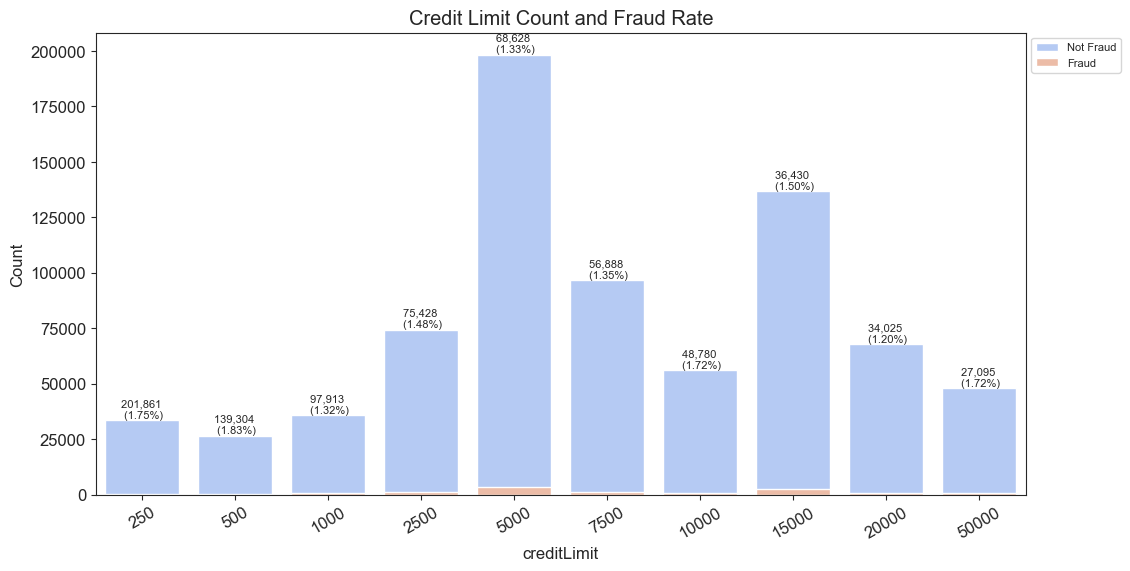

In [101]:
# Bar plots of the 'creditLimit' grouped by the label column
fea = 'creditLimit'
order_use = sorted(df[fea].unique().astype(int))
plot_cate_by_label_rate(fea, x_cat_y, rotate=30,order_use=order_use, title='Credit Limit Count and Fraud Rate')

#### 4.4.2.4 acqCountry
Next, the count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find that the fraud rates of accounts acquired outside of US tend to be higher, although there are less than 1% in total counts. We might consider all non-US countries as one category, and all non-US merchants as one category, or delete all non-US accounts. 

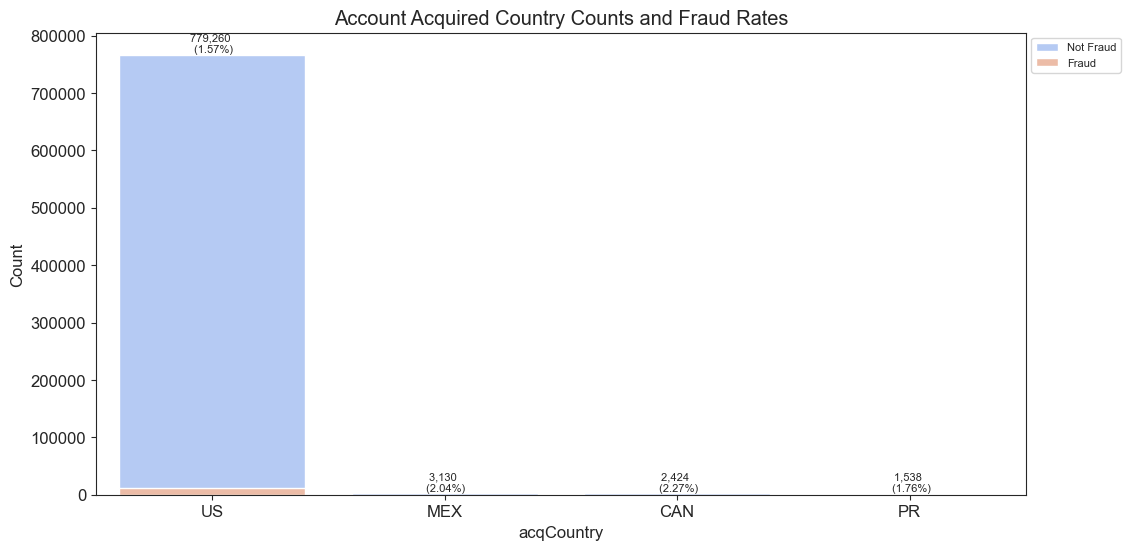

In [102]:
# Bar plots of the 'acqCountry' grouped by the label column
fea = 'acqCountry'
plot_cate_by_label_rate(fea, x_cat_y, rotate=0, title='Account Acquired Country Counts and Fraud Rates')

### 4.4.3 Merchant oriented features ['merchantName', 'merchantCountryCode', 'merchantCategoryCode'] and created feature 'countryMismatch'
The merchant oriented features have high cardinalities in the merchantName, we will use histograms and tables to demonstrate its distribution. In addition, We could also use the bar plots to show the distributions categorical features merchantCountryCode and merchantCategoryCode.

In [103]:
x_cat_y[['merchantName', 'merchantCountryCode', 'merchantCategoryCode']].nunique()

merchantName            205
merchantCountryCode       4
merchantCategoryCode     19
dtype: int64

#### 4.4.3.1 merchantName

We cannot plot all 205 merchant in 1 baaccounts acquired outside of US tend to be higher, although r plot, hence we will only plot the top 10 merchants here. The count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. 

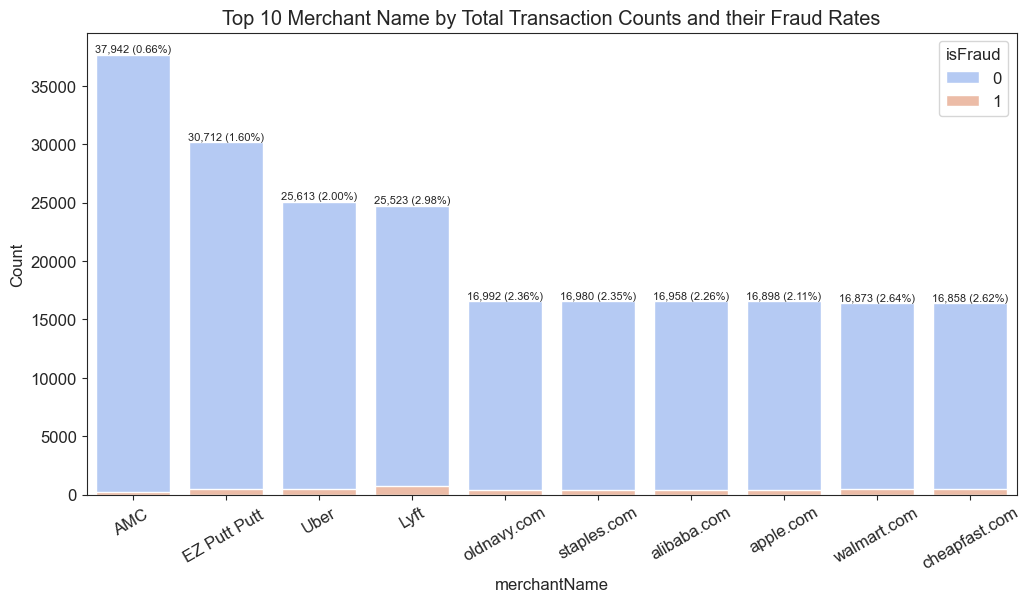

In [104]:
# Bar plots of the 'merchantName' grouped by the label column
fea = 'merchantName'
order_use = df[fea].value_counts(ascending=False).index[:10]
hue_label, rotate = 'isFraud', 30
title = 'Top 10 Merchant Name by Total Transaction Counts and their Fraud Rates'
ax = sns.countplot(x=fea, data=df, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = df[fea].value_counts(ascending=False)[:10]
rel_values = df.groupby(fea)['isFraud'].mean().loc[df[fea].value_counts(ascending=False).index]
lbls = [f'{a:,} ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8)
ax.set_ylabel('Count')
plt.show()


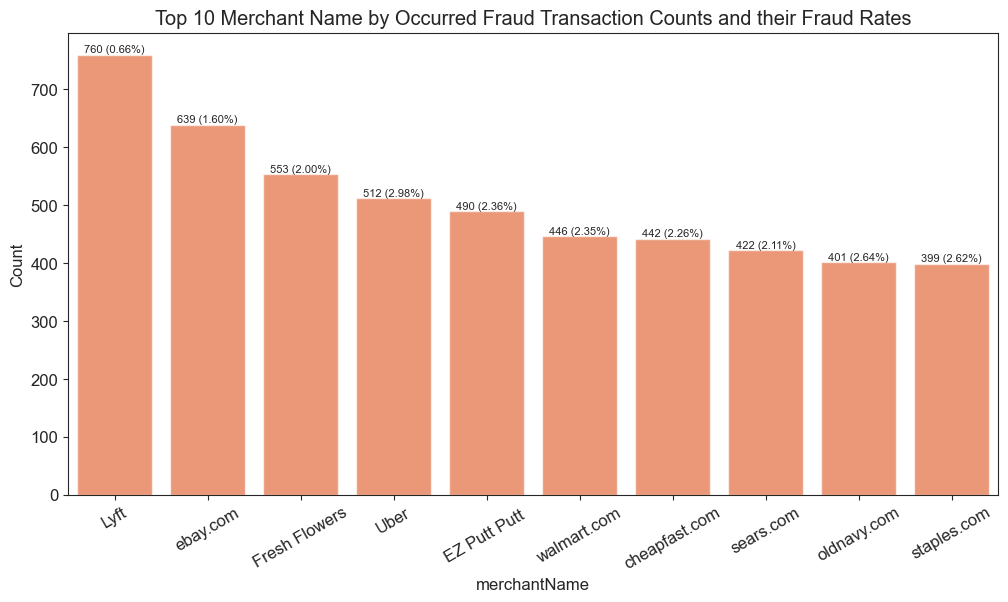

In [105]:
# Bar plots of the 'merchantName' grouped by the label column
fea = 'merchantName'
order_use = df[df['isFraud']==1]['merchantName'].value_counts().sort_values(ascending=False).index[:10]
hue_label, rotate = 'isFraud', 30
title = 'Top 10 Merchant Name by Occurred Fraud Transaction Counts and their Fraud Rates'
ax = sns.countplot(x=fea, data=df[df['isFraud']==1], order=order_use, color='orangered', alpha=0.6)
abs_values = df[df['isFraud']==1]['merchantName'].value_counts().sort_values(ascending=False)[:10]
rel_values = df.groupby(fea)['isFraud'].mean().loc[df[fea].value_counts(ascending=False).index][:10]
lbls = [f'{a:,} ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8)
ax.set_ylabel('Count')
plt.show()

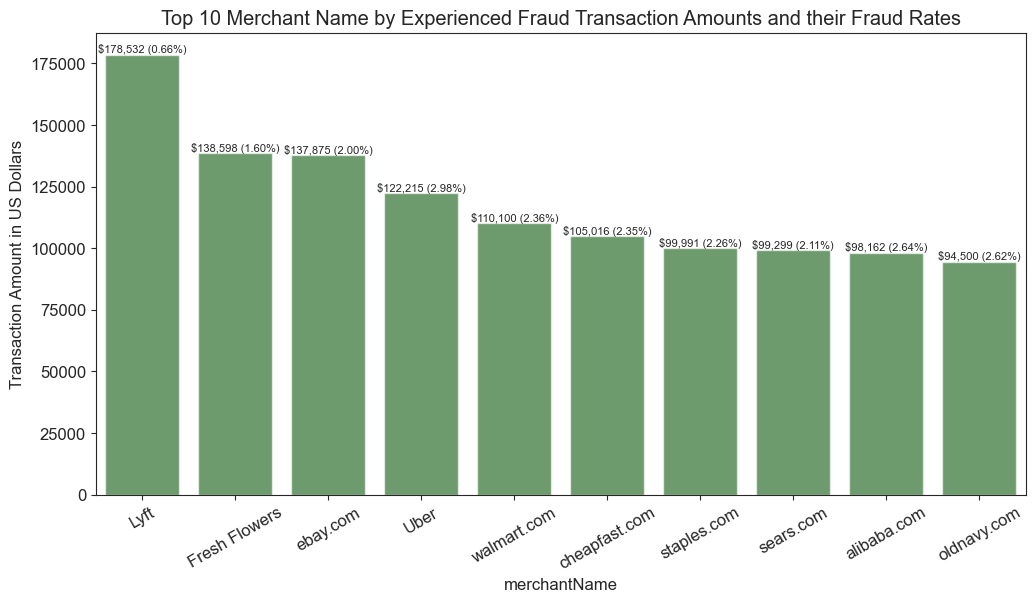

In [106]:
# Bar plots of the 'merchantName' grouped by the label column, but the y axis is the sum of transactionAmount
fea = 'merchantName'
order_use = df[df['isFraud']==1].groupby('merchantName')['transactionAmount'].sum().sort_values(ascending=False).index[:10]
hue_label, rotate = 'isFraud', 30
title = 'Top 10 Merchant Name by Experienced Fraud Transaction Amounts and their Fraud Rates'
ax = sns.barplot(x=fea, data=df[df['isFraud']==1].groupby('merchantName')['transactionAmount'].sum().sort_values(ascending=False).reset_index(), y='transactionAmount', order=order_use, color='darkgreen', alpha=0.6)
abs_values = df[df['isFraud']==1].groupby('merchantName')['transactionAmount'].sum().sort_values(ascending=False)[:10]
rel_values = df.groupby(fea)['isFraud'].mean().loc[df[fea].value_counts(ascending=False).index][:10]
lbls = [f'${a:,.0f} ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8)
ax.set_ylabel('Transaction Amount in US Dollars')
plt.show() 

In [107]:
# find out which merchantName has more than 1 merchantCategoryCode
a = df[['merchantName', 'merchantCategoryCode']].groupby('merchantName')['merchantCategoryCode'].nunique()
a[a>1]

merchantName
Golds Gym     2
Name: merchantCategoryCode, dtype: int64

In [108]:
# list the record counts with the merchantName 'Golds Gym ' but different merchantCategoryCode
df[df['merchantName']=='Golds Gym '][['merchantName', 'merchantCategoryCode']].value_counts()

merchantName  merchantCategoryCode
Golds Gym     health                  2555
              gym                      382
Name: count, dtype: int64

In [109]:
# change the 'merchantCategoryCode' column of the 'Golds Gym ' merchantName to 'gym'
df.loc[df['merchantName']=='Golds Gym ', 'merchantCategoryCode'] = 'gym'

In [110]:
# # find the value counts of merchantName in df and include their corresponding merchantCategoryCode, then save it to a .csv file
# merchantName_value_counts = df['merchantName'].value_counts()
# merchantName_value_counts = merchantName_value_counts.reset_index()
# merchantName_value_counts.columns = ['merchantName', 'count']

#### 4.4.3.2 merchantCountryCode
Next, the count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find that the fraud rates of merchants outside of US tend to be higher, although there are less than 1% in total counts. We might consider all non-US countries as one category, and all non-US merchants as one category, or delete all non-US accounts. 

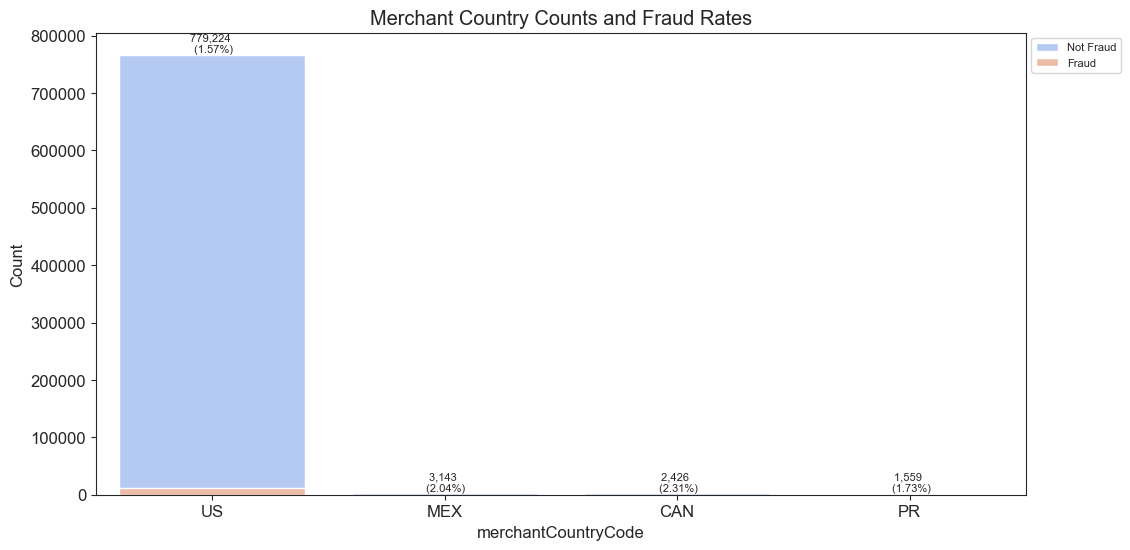

In [111]:
# Bar plots of the 'merchantCountryCode' grouped by the label column
fea = 'merchantCountryCode'
plot_cate_by_label_rate(fea, x_cat_y, rotate=0, title='Merchant Country Counts and Fraud Rates')

#### 4.4.3.3 merchantCategory
Next, the count plot by fraud(orange) or legitimate(blue) for each type is presented below along with the type-wise count and fraud rate on top of each bar. We find that the fraud rates of merchants belong to ['online_retail', 'online_gifts', 'rideshare'] are most susceptible hence required more attentions, whereas the 'fuel' type is literally fraud-free.

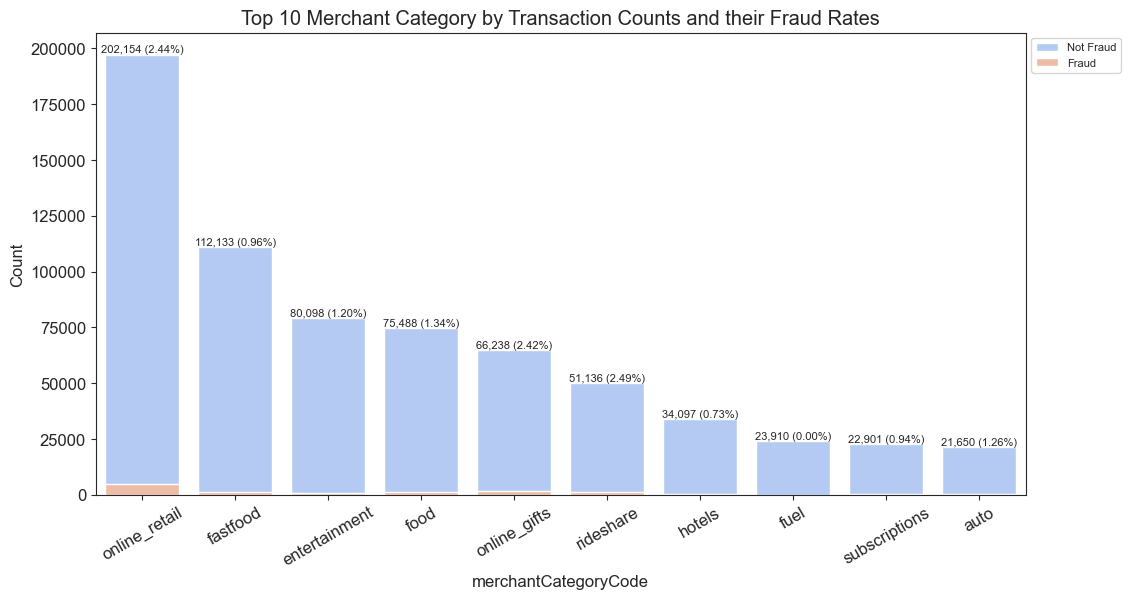

In [112]:
# Bar plots of the 'merchantCategory' grouped by the label column
fea = 'merchantCategoryCode'
order_use = df[fea].value_counts(ascending=False).index[:10]
hue_label, rotate = 'isFraud', 30
title = 'Top 10 Merchant Category by Transaction Counts and their Fraud Rates'
ax = sns.countplot(x=fea, data=df, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = df[fea].value_counts(ascending=False)[:10]
rel_values = df.groupby(fea)['isFraud'].mean().loc[df[fea].value_counts(ascending=False).index]
lbls = [f'{a:,} ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=8)
ax.set_ylabel('Count')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=8)
plt.show()

#### 4.4.3.4. countryMismatch
We create a new column 'countryMismatch' in the x_cat_y dataframe by comparing the 'acqCountry' with the 'merchantCountryCode'. After imputing the missing values in the countries, we found that the mismatch case is both low in counts and show no significance in the fraud rate. Therefore, we will consider exclude this feature from our model analysis.

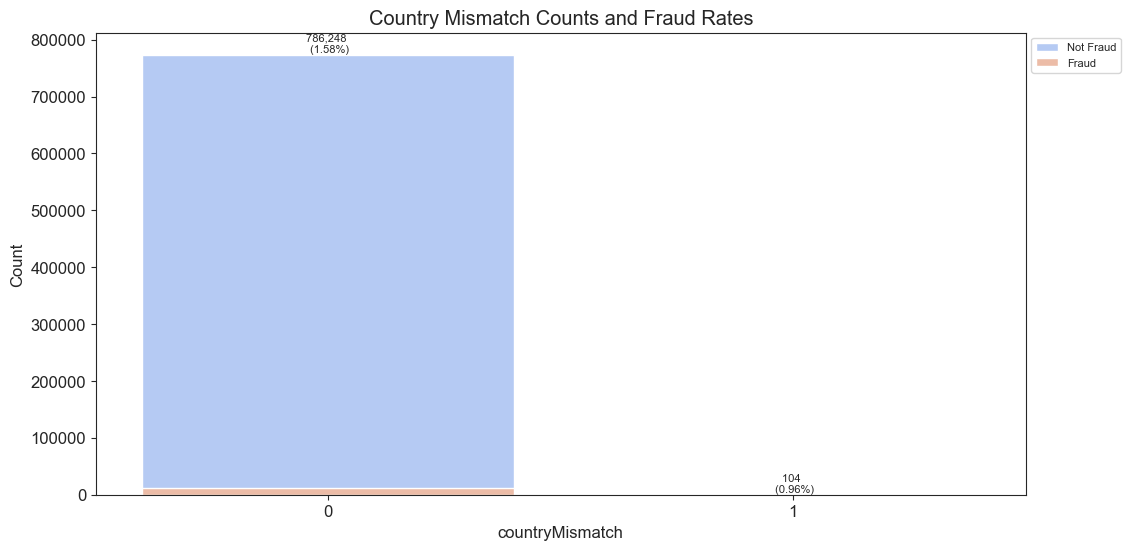

In [113]:
# create a new column 'countryMismatch' in the x_cat_y dataframe by comparing the 'acqCountry' with the 'merchantCountryCode'. If they are the same, assign 0, otherwise assign 1. Then plot the bar plot of the 'countryMismatch' grouped by the label column
x_cat_y['countryMismatch'] = (x_cat_y['acqCountry'] != x_cat_y['merchantCountryCode']).astype(int)
df['countryMismatch'] = (df['acqCountry'] != df['merchantCountryCode']).astype(int)
plot_cate_by_label_rate('countryMismatch', x_cat_y, rotate=0, title='Country Mismatch Counts and Fraud Rates')

### 4.4.4 Time oriented features ['x_hr', 'x_d', 'x_DOW', 'x_mon']
The time oriented features listed here are primarily used for solely EDA purpose. We will build more fitting historical aggregated time related features later during the feature engineering phase. 

#### 4.4.4.1. x_hr, the hour of the transaction took place

The distribution of total transaction spreads rather uniformly evenly among 24 hours, whereas the count of fraudulent transactions tend to have a peak around 3 p.m. 

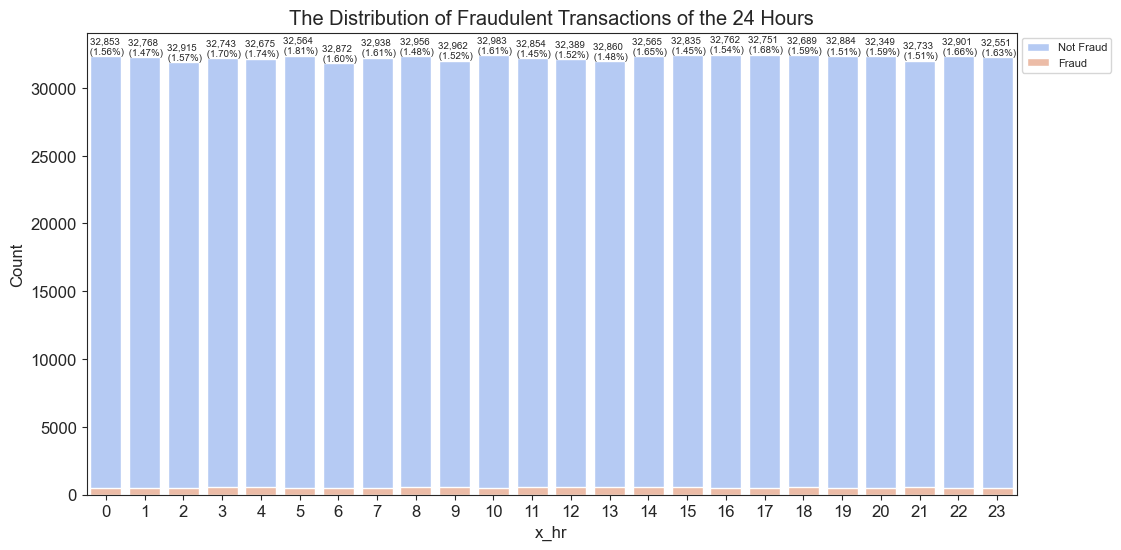

In [114]:
fea = 'x_hr'
order_use = range(24)
hue_label, rotate = 'isFraud', 0
title = 'The Distribution of Fraudulent Transactions of the 24 Hours'
ax = sns.countplot(x=fea, data=x_cat_y, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = x_cat_y[fea].value_counts().sort_index()
rel_values = x_cat_y.groupby(fea)['isFraud'].mean()
lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=7)
ax.set_ylabel('Count')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=8)
plt.show()

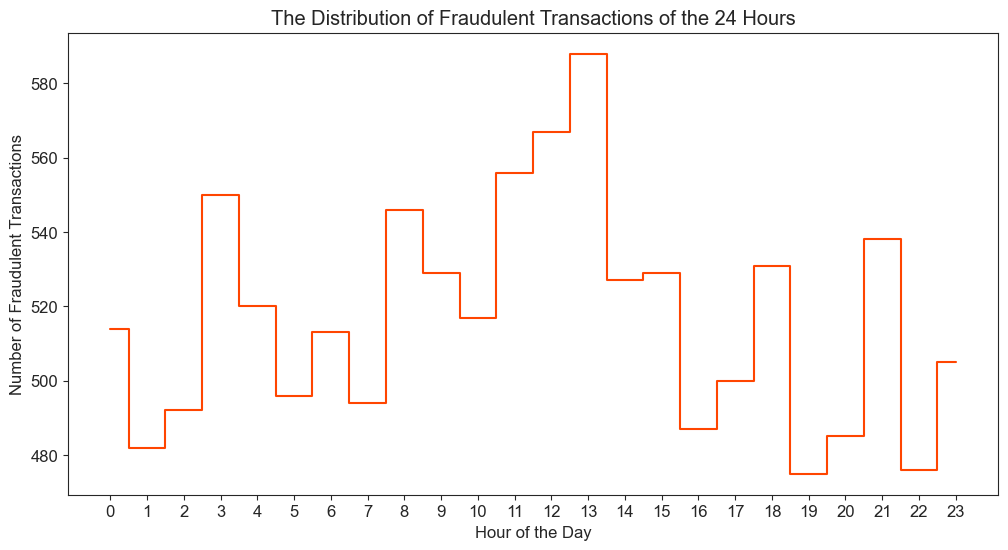

In [115]:
# At which hour of the day do the most fraudulent transactions occur?
# The most fraudulent transactions occur at 3 pm.
a = df[df['isFraud']==1]['x_hr'].value_counts().reset_index()
a['x_hr'] = a['x_hr'].astype(int)
a = a.sort_values(by='x_hr')
sns.lineplot(x='x_hr', y='count', data=a, drawstyle='steps-mid', color='orangered')
plt.title('The Distribution of Fraudulent Transactions of the 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(24))
plt.show()

#### 4.4.4.2. x_d, the day of the transaction took place

The distribution of total transaction spreads rather uniformly evenly among the entire month, except for some months don't have 31 or 30. The count of fraudulent transactions also tend to be smooth, except for a very shallow dip around 18th of each month.

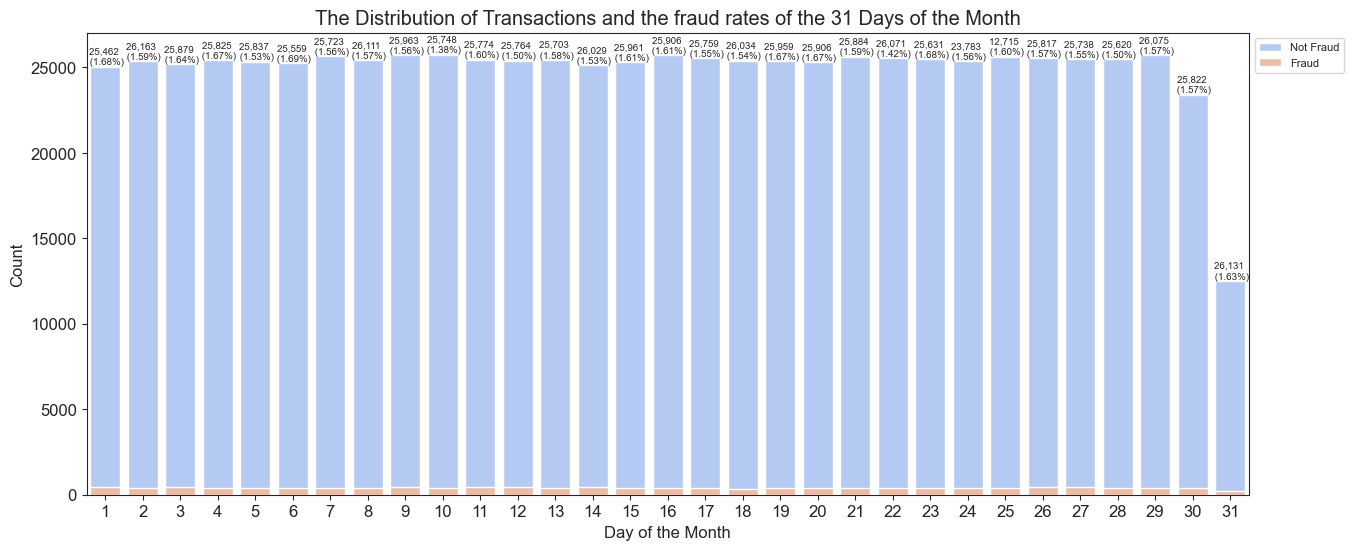

In [116]:
fea = 'x_d'
order_use = range(1,32)
hue_label, rotate = 'isFraud', 0
title = 'The Distribution of Transactions and the fraud rates of the 31 Days of the Month'
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(x=fea, data=x_cat_y, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = x_cat_y[fea].value_counts().sort_index()
rel_values = x_cat_y.groupby(fea)['isFraud'].mean()
lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=7)
ax.set_ylabel('Count')
plt.xlabel('Day of the Month')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=8)
plt.show()

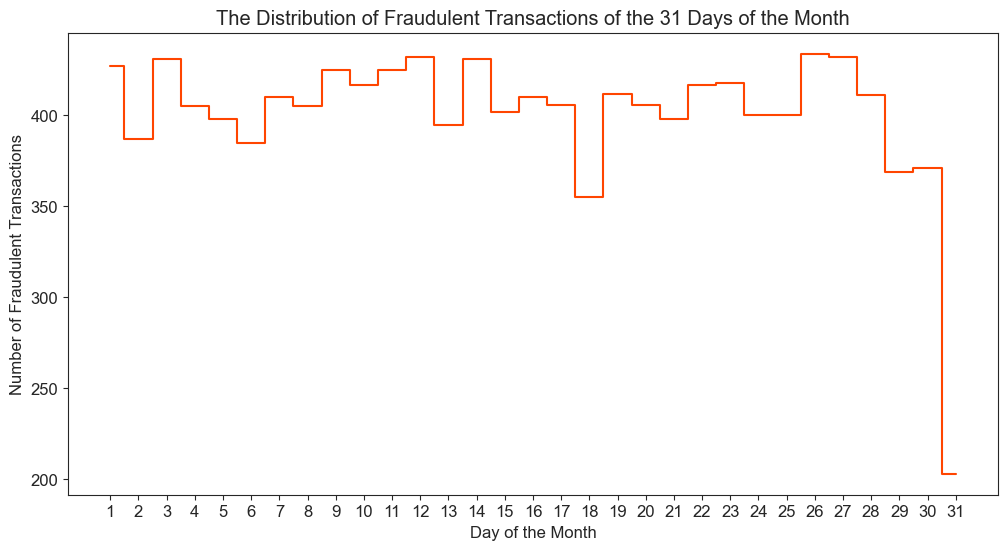

In [117]:
# At which day do the most fraudulent transactions occur?
a = df[df['isFraud']==1][fea].value_counts().reset_index()
a[fea] = a[fea].astype(int)
a = a.sort_values(by=fea)
sns.lineplot(x=fea, y='count', data=a, drawstyle='steps-mid', color='orangered')
plt.title('The Distribution of Fraudulent Transactions of the 31 Days of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(1,32))
plt.show()

#### 4.4.4.3. x_DOW, the day of week of the transaction took place

The distribution of total transaction spreads rather uniformly evenly among the entire week, with only Friday standing out. On top of that, the count of fraudulent transactions also tend to have a prominent peak on Friday, ensued by a huge dig on the weekends. 

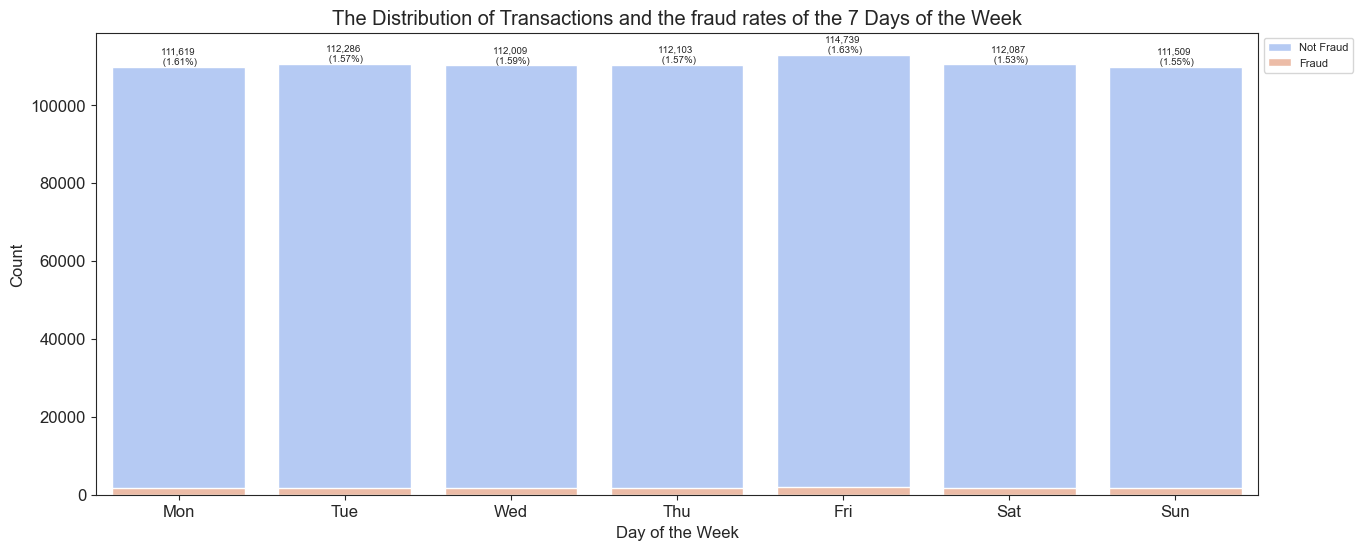

In [118]:
fea = 'x_DOW'
order_use = range(7)
title = 'The Distribution of Transactions and the fraud rates of the 7 Days of the Week'
hue_label, rotate = 'isFraud', 0
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(x=fea, data=x_cat_y, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = x_cat_y[fea].value_counts().sort_index()
rel_values = x_cat_y.groupby(fea)['isFraud'].mean()
lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=7)
ax.set_ylabel('Count')
plt.xlabel('Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=8)
plt.show()

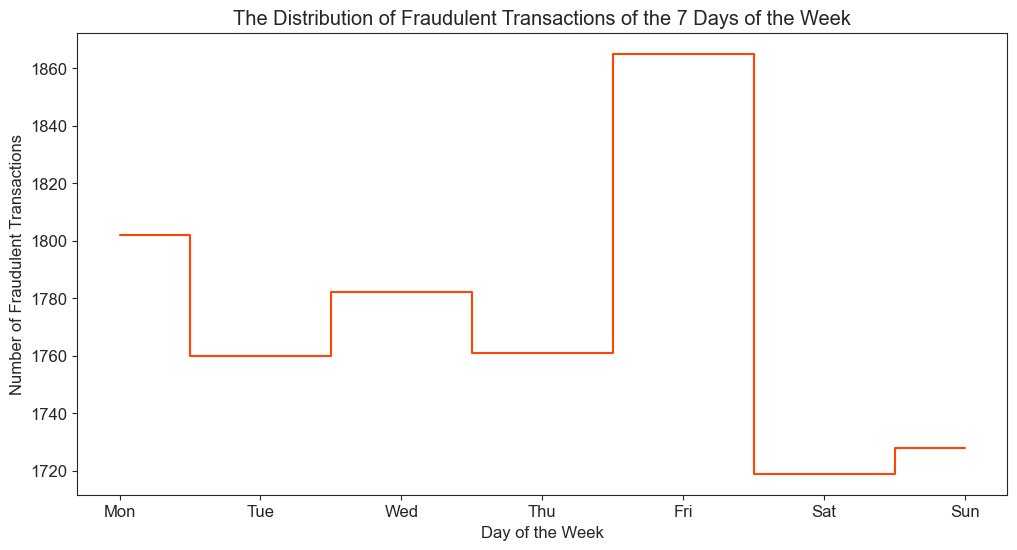

In [119]:
# At which day do the most fraudulent transactions occur?
a = df[df['isFraud']==1][fea].value_counts().reset_index()
a[fea] = a[fea].astype(int)
a = a.sort_values(by=fea)
sns.lineplot(x=fea, y='count', data=a, drawstyle='steps-mid', color='orangered')
plt.title('The Distribution of Fraudulent Transactions of the 7 Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

#### 4.4.4.4. x_mon, the month of the transaction took place

The distribution of total monthly counts of transaction is not uniform. It is very clear that the first six months are lower in the counts, whereas the count from July to December are much higher on average. On the contrary, the fraud rates are higher in the fist half of the year. On top of that, the count of fraudulent monthly transactions tend to show a prominent valley in November. 

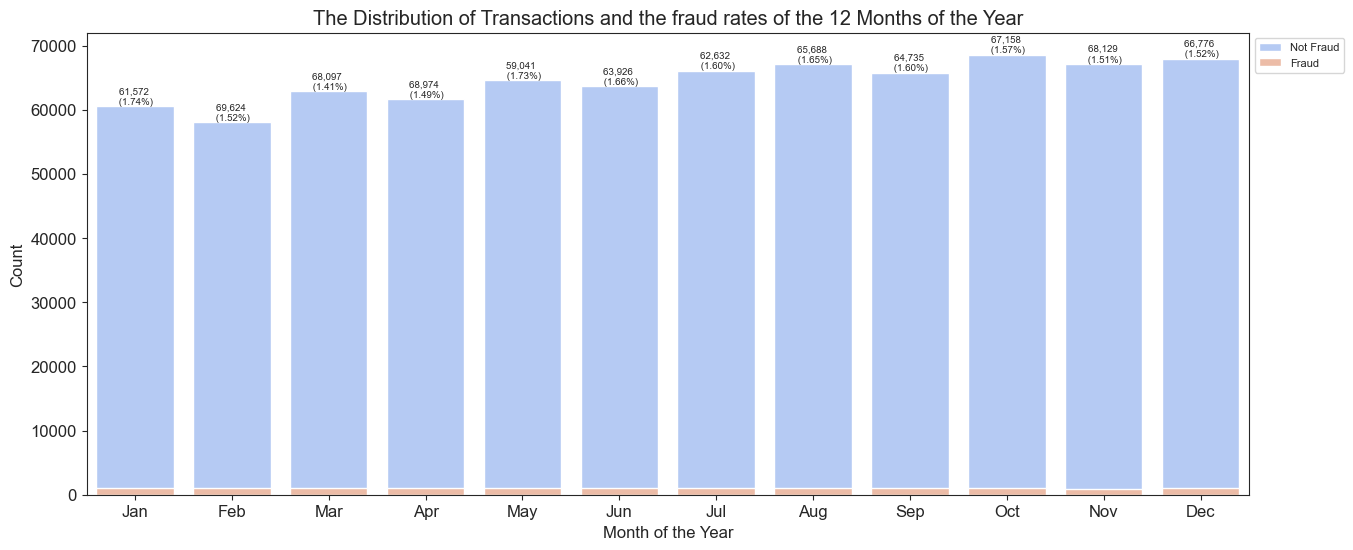

In [120]:
fea = 'x_mon'
order_use = range(1,13)
title = 'The Distribution of Transactions and the fraud rates of the 12 Months of the Year'
fig, ax = plt.subplots(figsize=(15, 6))
hue_label, rotate = 'isFraud', 0
ax = sns.countplot(x=fea, data=x_cat_y, order=order_use, hue=hue_label, palette='coolwarm', dodge=False)
abs_values = x_cat_y[fea].value_counts().sort_index()
rel_values = x_cat_y.groupby(fea)['isFraud'].mean()
lbls = [f'{a:,} \n ({b:.2%})' for a, b in zip(abs_values, rel_values)]
for label in ax.get_xticklabels():
    label.set_rotation(rotate)
if title is not None:
    ax.set_title(title)
if any(lbls) is not None:
    ax.bar_label(container=ax.containers[0], labels=lbls, fontsize=7)
ax.set_ylabel('Count')
plt.xlabel('Month of the Year')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1), labels=['Not Fraud', 'Fraud'], title=None, fontsize=8)
plt.show()

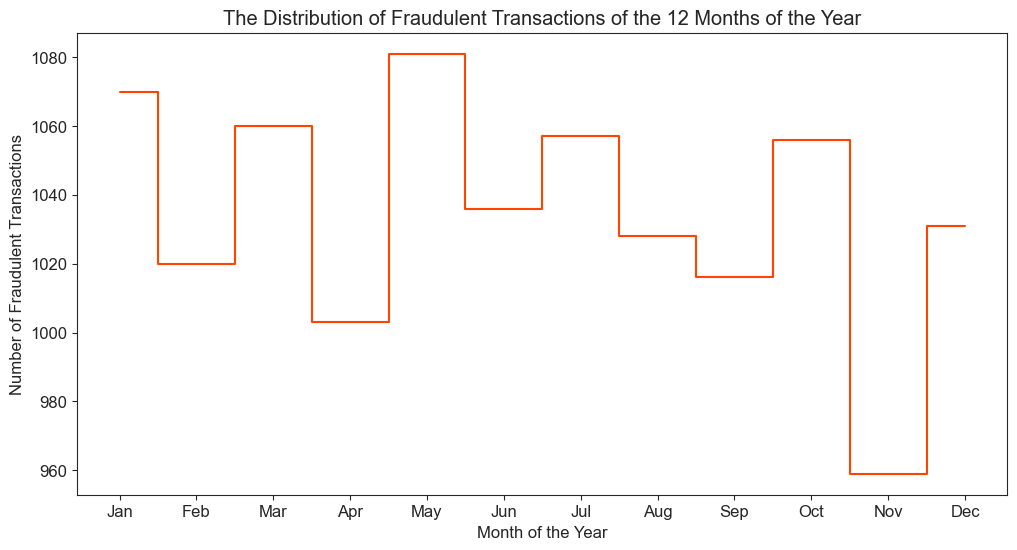

In [121]:
# At which day do the most fraudulent transactions occur?
a = df[df['isFraud']==1][fea].value_counts().reset_index()
a[fea] = a[fea].astype(int)
a = a.sort_values(by=fea)
sns.lineplot(x=fea, y='count', data=a, drawstyle='steps-mid', color='orangered')
plt.title('The Distribution of Fraudulent Transactions of the 12 Months of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# 5. Feature Engineering

## 5.1 Feature engineering that has already been conducted in previous steps
Based on the preprocessing and exploratory data analysis, we have already conducted some feature engineering, for example:
- Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'],
- Drop the redundant ['customerId'] column,
- Extract the day, month, year of the transactions and convert the ['accountOpenDate', 'dateOfLastAddressChange','currentExpDate'] to numeric features as ['d_since_open', 'd_since_update_add', 'd_2_exp'],
- Coalesce the information contained in ['cardCVV', 'enteredCVV'] columns to a new categorical ['mismatchInCVV'] column showing the number of mismatches by comparing the 3 integers in each row of the two CVV columns,
- Continue to include ['acqCountry', 'merchantCountryCode'] columns and discard the newly added boolean ['countryMismatch'] showing if the country code in the previous two columns are equal due to the result of EDA,
- Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205,
- Replace ['currentBalance','availableMoney'] to ['creditUtilizationRate', 'availableMoneyRate'] to reflect the 'creditLimit',
- Drop the ['x_hr', 'x_d', 'x_mon'] columns for they don't show discriminating contribution to the classification in the EDA,
- Normalize the numeric features ['transactionAmount', 'd_since_open', 'd_since_update_add', 'd_2_exp'] and drop the original ones,
- Combined the ['accountNumber', 'cardLast4Digits'] as ['UID'] and use it as the new identifier of account user. 

In [122]:
# drop the columns 'countryMismatch', 'x_hr', 'x_d', 'x_mon', 'countryMismatch', 'transactionAmount', 'd_since_open', 'd_since_update_add', 'd_2_exp'
df.drop(columns=['countryMismatch', 'x_hr', 'x_d', 'x_mon', 'countryMismatch'], inplace=True) 
df.drop(columns=['transactionAmount', 'd_since_open', 'd_since_update_add', 'd_2_exp'], inplace=True)
# change the column name of 'accountNumber+4Digits' to 'UID'
df.rename(columns={'accountNumber+4Digits':'UID'}, inplace=True)
# save the preprocessed data to disk, and describe their unique values
joblib.dump(df, 'data_b4_agg.pkl')
df.nunique()

creditLimit                     10
transactionDateTime         776626
merchantName                   205
acqCountry                       4
merchantCountryCode              4
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
transactionType                  4
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
x_DOW                            7
mismatchInCVV                    4
creditUtilizationRate       537513
availableMoneyRate          535417
transactionAmount_norm       66027
d_since_open_norm             5102
d_since_update_add_norm       4810
d_2_exp_norm                  5356
UID                           7380
dtype: int64

In [123]:
base_features = df.drop(columns='isFraud', inplace=False).columns.tolist()
print(f'There are {len(base_features)} base features. They are {base_features}.')

There are 20 base features. They are ['creditLimit', 'transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch', 'x_DOW', 'mismatchInCVV', 'creditUtilizationRate', 'availableMoneyRate', 'transactionAmount_norm', 'd_since_open_norm', 'd_since_update_add_norm', 'd_2_exp_norm', 'UID'].


## 5.2 Feature engineering to be executed, historical aggregates

Given the temporal structure of the transactional dataset, it is customary to complement a selection of the base categorical features with their own historical aggregates in the final model to boost its performance. The purpose is similar to the idea of the auto-regressive approach on the numeric features of time series that utilizing the past data to predict the future. Assuming the independence between different users, we will pull off the aggregates on a user level. In the practice, based on the temporal order indicated by the 'transactionDateTime' column, we will group-by on the 'UID' column or 'UID' plus another features as a set, then calculate the following aggregates for any transaction record by its predecessor transactions made by the same user: 

1. Recency: the time in minutes since last occurrence a transaction has been seen with the same attribute(s);
2. Age: the time in minutes after the first occurrence a transaction has been seen with the same attribute(s);
3. Count: the number of transactions have occurred before with the same attribute(s);
4. Sum: the cumulative summation of transaction amount of transactions have occurred before with the same attribute(s).

It should be noted that we manually define the recencies for all the first occurrence as 0. Finally, since we are doing the historical aggregates on an UID/user level, there is no need to perform it on account-oriented features like 'creditLimit' and 'acqCountry' for they are tied with an account. Therefore, we will conduct the aggregates on the rest merchant-oriented and transaction-oriented features.

In [124]:
feas_to_agg = ['transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 'merchantName', 'merchantCategoryCode', 'merchantCountryCode']
agged_list = [["UID"]]
for f in feas_to_agg:
    agged_list.append(["UID", f])
print(f'We will add historical aggregated features for the following {len(feas_to_agg)} features: {feas_to_agg}.\nThey are {agged_list}.')

We will add historical aggregated features for the following 9 features: ['transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 'merchantName', 'merchantCategoryCode', 'merchantCountryCode'].
They are [['UID'], ['UID', 'transactionType'], ['UID', 'posEntryMode'], ['UID', 'posConditionCode'], ['UID', 'cardPresent'], ['UID', 'expirationDateKeyInMatch'], ['UID', 'mismatchInCVV'], ['UID', 'merchantName'], ['UID', 'merchantCategoryCode'], ['UID', 'merchantCountryCode']].


In [125]:
df = joblib.load('data_b4_agg.pkl')
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [126]:
# create a new dataframe to hold the result of the historical aggregates
agg_features = []
for attrs in agged_list:
    # print(attrs)
    df.sort_values(by= attrs+['transactionDateTime'], inplace=True)
    # create the recency aggregates
    df[f'recency_by_{"_".join(attrs)}'] = df.groupby(attrs)['transactionDateTime'].diff().dt.total_seconds().fillna(0) / 60
    # create the age aggregates
    df[f'age_by_{"_".join(attrs)}'] = df.groupby(attrs)[f'recency_by_{"_".join(attrs)}'].cumsum()
    # create the transaction count aggregates
    df[f'count_by_{"_".join(attrs)}'] = df.groupby(attrs).cumcount()
    # create the normalized transaction amount sum aggregates
    df[f'sum_by_{"_".join(attrs)}'] = df.groupby(attrs)['transactionAmount_norm'].cumsum()

    # append the new features to the list of aggregated features
    agg_features.extend([f'recency_by_{"_".join(attrs)}', f'age_by_{"_".join(attrs)}', f'count_by_{"_".join(attrs)}', f'Sum_by_{"_".join(attrs)}'])

In [127]:
print(f"We added {len(agg_features)} historical aggregated features. They are : {agg_features}.")

We added 40 historical aggregated features. They are : ['recency_by_UID', 'age_by_UID', 'count_by_UID', 'Sum_by_UID', 'recency_by_UID_transactionType', 'age_by_UID_transactionType', 'count_by_UID_transactionType', 'Sum_by_UID_transactionType', 'recency_by_UID_posEntryMode', 'age_by_UID_posEntryMode', 'count_by_UID_posEntryMode', 'Sum_by_UID_posEntryMode', 'recency_by_UID_posConditionCode', 'age_by_UID_posConditionCode', 'count_by_UID_posConditionCode', 'Sum_by_UID_posConditionCode', 'recency_by_UID_cardPresent', 'age_by_UID_cardPresent', 'count_by_UID_cardPresent', 'Sum_by_UID_cardPresent', 'recency_by_UID_expirationDateKeyInMatch', 'age_by_UID_expirationDateKeyInMatch', 'count_by_UID_expirationDateKeyInMatch', 'Sum_by_UID_expirationDateKeyInMatch', 'recency_by_UID_mismatchInCVV', 'age_by_UID_mismatchInCVV', 'count_by_UID_mismatchInCVV', 'Sum_by_UID_mismatchInCVV', 'recency_by_UID_merchantName', 'age_by_UID_merchantName', 'count_by_UID_merchantName', 'Sum_by_UID_merchantName', 'recency

In [128]:
# save the preprocessed data after aggregate to disk along with the 
joblib.dump(df, 'data_after_agg.pkl')
joblib.dump(agg_features, 'agg_features.pkl')
joblib.dump(base_features, 'base_features.pkl')
print(f'The data after aggregation has {df.shape[0]:,} rows and {df.shape[1]-1} features aside from the target.')

The data after aggregation has 786,352 rows and 60 features aside from the target.


# 6. Train/Validation/Test Split

To properly evaluate all models' performances, we need  
Split the data into train, validation, and test sets via stratified random sampling while keeping the ratio of the target column 'isFraud' the same in each set.


In [5]:
df = joblib.load('data_after_agg.pkl')
base_features = joblib.load('base_features.pkl')
agg_features = joblib.load('agg_features.pkl')

print(f'The data after aggregation has {df.shape[0]:,} rows and {df.shape[1]-1} features aside from the target.')

The data after aggregation has 786,352 rows and 60 features aside from the target.


In [6]:
# Split the df into non-test and test data based on the transactionDateTime on or after 2016-11-01
test_data = df[df['transactionDateTime']>='2016-11-01']
non_test_data = df[df['transactionDateTime']<'2016-11-01']
# Separate features and target
X_non_test = non_test_data.drop(columns=['isFraud'])
y_non_test = non_test_data['isFraud']
X_test = test_data.drop(columns=['isFraud'])
y_test = test_data['isFraud']
# Initialize the StratifiedKFold for cross-validation
skf = StratifiedKFold(shuffle=True, random_state=7)

In [7]:
# Print the number of unique UIDs in the test set and the original dataset
print(f"There are {test_data['UID'].nunique()} unique UIDs in the test set, compared to the {df['UID'].nunique()} unique UIDs in the original dataset.\n")

# Iterate over the splits and print the indices of each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_non_test, y_non_test)):
    print(f"Fold {fold + 1}")
    print("TRAIN indices:", train_index)
    print("VALIDATION indices:", val_index)
    # Calculate class distribution ratios
    train_class_ratios = y_non_test.iloc[train_index].value_counts(normalize=True)
    val_class_ratios = y_non_test.iloc[val_index].value_counts(normalize=True)
    print(f"Training class distribution: {train_class_ratios.to_dict()}")
    print(f"Validation class distribution: {val_class_ratios.to_dict()}")
    print("\n")
print(f'The class distribution of the target in the test set is {y_test.value_counts(normalize=True).to_dict()}.\n')

# print the shape of the X of train, validation, and test sets
print(f"The shape of the train X is {(len(train_index), X_non_test.shape[1])}.")
print(f"The shape of the validation X is {(len(val_index), X_non_test.shape[1])}.")
print(f"The shape of the test X is {X_test.shape}.\n")

There are 6793 unique UIDs in the test set, compared to the 7380 unique UIDs in the original dataset.

Fold 1
TRAIN indices: [     0      1      3 ... 649278 649279 649280]
VALIDATION indices: [     2      5     10 ... 649267 649272 649275]
Training class distribution: {0: 0.9839418278708724, 1: 0.01605817212912765}
Validation class distribution: {0: 0.9839361759473882, 1: 0.016063824052611718}


Fold 2
TRAIN indices: [     0      2      5 ... 649277 649278 649280]
VALIDATION indices: [     1      3      4 ... 649268 649270 649279]
Training class distribution: {0: 0.9839399335804014, 1: 0.016060066419598593}
Validation class distribution: {0: 0.9839437530803351, 1: 0.016056246919664858}


Fold 3
TRAIN indices: [     0      1      2 ... 649278 649279 649280]
VALIDATION indices: [     9     17     18 ... 649265 649273 649276]
Training class distribution: {0: 0.9839399335804014, 1: 0.016060066419598593}
Validation class distribution: {0: 0.9839437530803351, 1: 0.016056246919664858}


Fold

# 7. Modeling
## 7.1 Baseline Model - Class weighted Logistic Regression


In [32]:
df = joblib.load('data_after_agg.pkl')
# Encode the categorical features in the training set respectively
oh_enc = OneHotEncoder(handle_unknown='error', dtype=np.int8, sparse_output=False, drop='first')
ord_enc = OrdinalEncoder(handle_unknown='error', min_frequency=0.005, dtype=np.int8)
# hasher = FeatureHasher(input_type='string', dtype=np.int8, n_features=2**13)
# Apply the encoding to the test and non-test data
oh_features = ['acqCountry', 'transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 'merchantCategoryCode', 'merchantCountryCode', 'x_DOW', 'merchantName']
ord_features = ['creditLimit']
#hash_features = ['merchantName', 'UID']
num_features = ['creditUtilizationRate', 'availableMoneyRate', 'transactionAmount_norm', 'd_since_open_norm', 'd_since_update_add_norm', 'd_2_exp_norm']

In [33]:
# Convert the single string in df[hash_features] to a list of strings
# for fea in hash_features:
#     df[fea] = df[fea].apply(lambda x: [x] if isinstance(x, str) else x)
# fit and transform the categorical features
df_oh = oh_enc.fit_transform(df[oh_features])
df_ord = ord_enc.fit_transform(df[ord_features])
# uid_hash = hasher.fit_transform(df['UID'])
# merchant_hash = pd.DataFrame(hasher.fit_transform(df['merchantName']))
# convert the categorical df[hash_features] to the frequency encoding
# merchantName_freq_encoder = df['merchantName'].value_counts(normalize=True)
# data_merchantName_freq = df['merchantName'].map(merchantName_freq_encoder)
UID_freq_encoder = df['UID'].value_counts(normalize=True)
data_UID_freq = df['UID'].map(UID_freq_encoder)
# get the feature names of the one-hot encoded features
oh_feature_names = oh_enc.get_feature_names_out(oh_features)
ord_feature_names = ord_enc.get_feature_names_out(ord_features)
#hash_feature_names = hasher.get_feature_names_out(hash_features)
# convert the df to the encoded dataframe
data_oh = pd.DataFrame(df_oh, columns=oh_feature_names, index=df.index)
date_ord = pd.DataFrame(df_ord, columns=ord_feature_names, index=df.index)
# uid_hash = pd.DataFrame(uid_hash, columns=[f'UID_{i}' for i in range(uid_hash.shape[1])], index=df.index)
data_num = df[num_features]
# concatenate the encoded dataframes
data_enc = pd.concat([data_oh, date_ord, data_num, data_UID_freq, df[['transactionDateTime','isFraud']]], axis=1)

In [34]:
data_enc.shape

(786352, 260)

In [35]:
# Split the data_enc into non-test and test data based on the transactionDateTime on or after 2016-11-01
test_data = data_enc[data_enc['transactionDateTime']>='2016-11-01']
train_data = data_enc[data_enc['transactionDateTime']<'2016-11-01']
# Separate features and target
X_train = train_data.drop(columns=['isFraud', 'transactionDateTime'])
y_train = train_data['isFraud']
X_test = test_data.drop(columns=['isFraud', 'transactionDateTime'])
y_test = test_data['isFraud']
# Initialize the StratifiedKFold for cross-validation
skf = StratifiedKFold(shuffle=True, random_state=7)

In [36]:
np.random.seed(7)
# Initialize the Logistic Regression model with class weights
model_lr = LogisticRegression( random_state=7, warm_start=True, max_iter=300)
# Define the hyperparameter grid to tune
param_grid_lr = {'C': [0.02, 0.025, 0.03],
                    'class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:21}],
              'solver': ['saga', 'newton-cholesky']}

# Custom Grid Search with tqdm progress bar
best_score = []
best_params = []

def product_of_lengths(d):
    # Initialize the product to 1
    product = 1
    # Iterate over the dictionary values
    for value in d.values():
        # Multiply the current product by the length of the value
        product *= len(value)
    return product

class TQDMProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="GridSearchCV")

    def __call__(self, *args, **kwargs):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

# Custom GridSearchCV class with tqdm progress bar
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = product_of_lengths(self.param_grid)
        total_iterations = n_candidates * self.cv.get_n_splits(X, y)
        progress_bar = TQDMProgressBar(total_iterations)
        
        def fit_and_score(*args, **kwargs):
            result = super(TQDMGridSearchCV, self)._fit_and_score(*args, **kwargs)
            progress_bar()
            return result
        
        self._fit_and_score = fit_and_score
        try:
            return super(TQDMGridSearchCV, self).fit(X, y, **fit_params)
        finally:
            progress_bar.close()

# Initialize the custom GridSearchCV object
grid_search_lr = TQDMGridSearchCV(model_lr, param_grid_lr, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=0)

# Fit the GridSearchCV object to the data
grid_search_lr.fit(X_train, y_train)
# Get the best parameters
best_params_lr = grid_search_lr.best_params_
# Get the best score
best_score_lr = grid_search_lr.best_score_
# make predictions on the test set
y_pred_lr = grid_search_lr.predict(X_test)
# calculate the roc_auc score on the test set
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
# calculate the f1 score on the test set
f1_lr = f1_score(y_test, y_pred_lr)
# Print the best parameters and score
print(f"The logistic regression best parameters are: {best_params_lr}")
print(f"The logistic regression roc_auc score on validation set is: {best_score_lr:.4f}")
print(f"The logistic regression roc_auc score on the test set is: {roc_auc_lr:.4f}")
# Save the best model using joblib
joblib.dump(grid_search_lr.best_estimator_, 'best_logistic_regression_model.pkl')
print("Model saved as 'best_logistic_regression_model.pkl'")

GridSearchCV:   0%|          | 0/90 [34:35<?, ?it/s]


The logistic regression best parameters are: {'C': 0.025, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}
The logistic regression roc_auc score on validation set is: 0.7691
The logistic regression roc_auc score on the test set is: 0.7155
Model saved as 'best_logistic_regression_model.pkl'


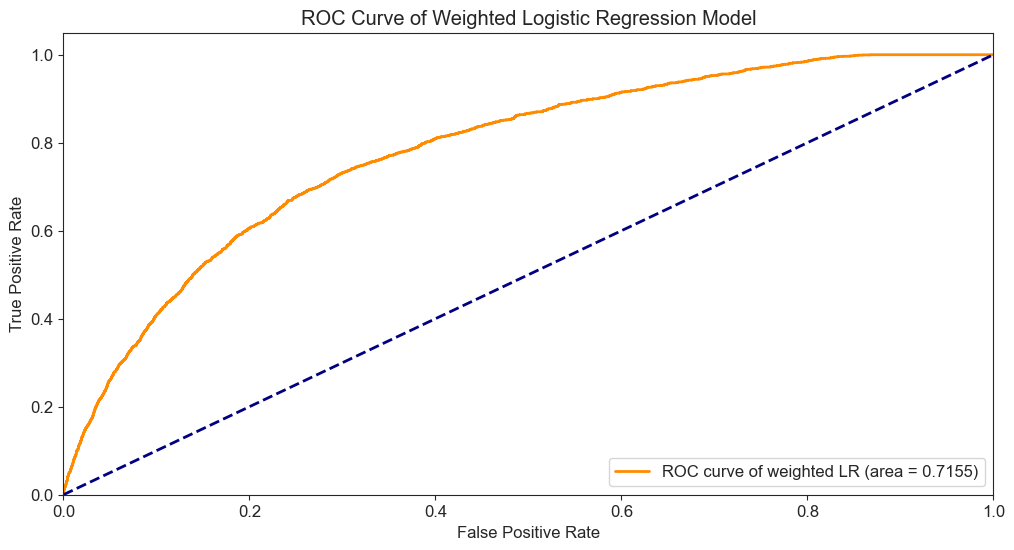

In [37]:
# append the best score and the best parameters to the best_score and best_params lists
best_score.append(best_score_lr)
best_params.append(best_params_lr)

# print the ROC curve via sklearn.metrics.roc_curve of the logistic regression model
fpr_lr, tpr_lr, _ = roc_curve(y_test, grid_search_lr.predict_proba(X_test)[:,1])
# plot the ROC curve
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve of weighted LR (area = %0.4f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Weighted Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

## 7.2 Class weighted SVM

In [41]:
# Encode the categorical features in the training set respectively
oh_enc = OneHotEncoder(handle_unknown='error', dtype=np.int8, sparse_output=False, drop='first')
ord_enc = OrdinalEncoder(handle_unknown='error', min_frequency=0.005, dtype=np.float16)
scaler = MinMaxScaler()
# hasher = FeatureHasher(input_type='string', dtype=np.int8, n_features=2**13)
# Apply the encoding to the test and non-test data
oh_features = ['acqCountry', 'transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 'expirationDateKeyInMatch', 'mismatchInCVV', 'merchantCategoryCode', 'merchantCountryCode', 'x_DOW']
ord_features = ['creditLimit']
#hash_features = ['merchantName', 'UID']
num_features = ['creditUtilizationRate', 'availableMoneyRate', 'transactionAmount_norm', 'd_since_open_norm', 'd_since_update_add_norm', 'd_2_exp_norm']

In [42]:
# Convert the single string in df[hash_features] to a list of strings
# for fea in hash_features:
#     df[fea] = df[fea].apply(lambda x: [x] if isinstance(x, str) else x)
# fit and transform the categorical features
df_oh = oh_enc.fit_transform(df[oh_features])
df_ord = scaler.fit_transform(df[ord_features].astype(int))
# uid_hash = hasher.fit_transform(df['UID'])
# merchant_hash = pd.DataFrame(hasher.fit_transform(df['merchantName']))
# convert the categorical df[hash_features] to the frequency encoding
merchantName_freq_encoder = df['merchantName'].value_counts(normalize=True)
data_merchantName_freq = df['merchantName'].map(merchantName_freq_encoder)
UID_freq_encoder = df['UID'].value_counts(normalize=True)
data_UID_freq = df['UID'].map(UID_freq_encoder)
# get the feature names of the one-hot encoded features
oh_feature_names = oh_enc.get_feature_names_out(oh_features)
# ord_feature_names = ord_enc.get_feature_names_out(ord_features)
# hash_feature_names = hasher.get_feature_names_out(hash_features)
# convert the df to the encoded dataframe
data_oh = pd.DataFrame(df_oh, columns=oh_feature_names, index=df.index)
date_ord = pd.DataFrame(df_ord, columns=['creditLimit'], index=df.index)
# uid_hash = pd.DataFrame(uid_hash, columns=[f'UID_{i}' for i in range(uid_hash.shape[1])], index=df.index)
data_num = df[num_features]
# concatenate the encoded dataframes
data_enc = pd.concat([data_oh, date_ord, data_num, data_UID_freq, df[['transactionDateTime','isFraud']]], axis=1)

In [43]:
data_enc.shape

(786352, 56)

In [44]:
# Split the data_enc into non-test and test data based on the transactionDateTime on or after 2016-11-01
test_data = data_enc[data_enc['transactionDateTime']>='2016-11-01']
train_data = data_enc[data_enc['transactionDateTime']<'2016-11-01']
# Separate features and target
X_train = train_data.drop(columns=['isFraud', 'transactionDateTime'])
y_train = train_data['isFraud']
X_test = test_data.drop(columns=['isFraud', 'transactionDateTime'])
y_test = test_data['isFraud']
# Initialize the StratifiedKFold for cross-validation
skf = StratifiedKFold(shuffle=True, random_state=7)

In [45]:
y_train.value_counts(normalize=True)

isFraud
0    0.983941
1    0.016059
Name: proportion, dtype: float64

In [83]:
m=3
(0.016063*m)/(.983941+0.016063*m)

0.046688886089930534

In [48]:
# Create a pipeline with StandardScaler and SVC
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(tol=5e-3, cache_size=8000, max_iter=6000, random_state=7))
])

# Define the hyperparameter grid to tune
param_grid_svm = {
    'svc__C': [0.2, 0.5, 1],
    'svc__degree': [3, 4],
    'svc__class_weight': [{0: 1, 1: 3}, {0: 1, 1: 21}, 'balanced'],
    'svc__kernel': ['poly']
}

# Initialize the custom GridSearchCV object
grid_search_svm = TQDMGridSearchCV(pipeline_svm, param_grid_svm, cv=skf, scoring='roc_auc', n_jobs=10, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_svm.fit(X_train, y_train)

# Get the best parameters
best_params_svm = grid_search_svm.best_params_

# Get the best score
best_score_svm = grid_search_svm.best_score_

# Make predictions on the test set
y_pred_svm = grid_search_svm.predict(X_test)

# Calculate the roc_auc score on the test set
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

# Calculate the f1 score on the test set
f1_svm = f1_score(y_test, y_pred_svm)

# Print the best parameters and score
print(f"The SVM best parameters are: {best_params_svm}")
print(f"The SVM roc_auc score on validation set is: {best_score_svm:.4f}")
print(f"The SVM roc_auc score on the test set is: {roc_auc_svm:.4f}")

# Save the best model using joblib
joblib.dump(grid_search_svm.best_estimator_, 'best_svm_model.pkl')
print("Model saved as 'best_svm_model.pkl'")

# Append the best score and the best parameters to the best_score and best_params lists
best_score.append(best_score_svm)
best_params.append(best_params_svm)

GridSearchCV:   0%|          | 0/90 [00:00<?, ?it/s]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\Han\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=6000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
GridSearchCV:   0%|          | 0/90 [2:50:55<?, ?it/s]


The SVM best parameters are: {'svc__C': 0.5, 'svc__class_weight': {0: 1, 1: 3}, 'svc__degree': 3, 'svc__kernel': 'poly'}
The SVM roc_auc score on validation set is: 0.5398
The SVM roc_auc score on the test set is: 0.5015
Model saved as 'best_svm_model.pkl'


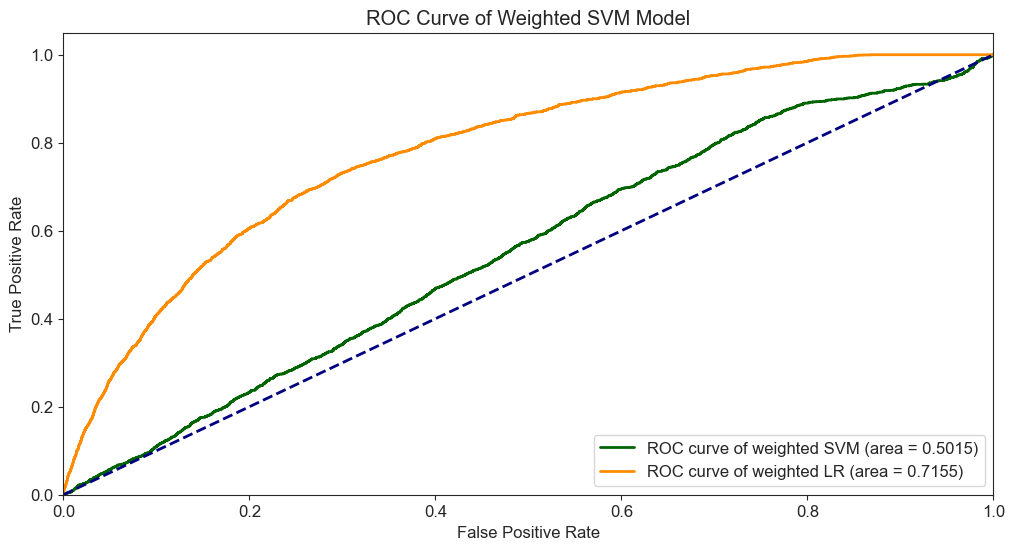

In [ ]:
# print the ROC curve via sklearn.metrics.roc_curve of the SVC model
fpr_svm, tpr_svm, _ = roc_curve(y_test, grid_search_svm.decision_function(X_test))
# plot the ROC curve
plt.plot(fpr_svm, tpr_svm, color='darkgreen', lw=2, label='ROC curve of weighted SVM (area = %0.4f)' % roc_auc_svm)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve of weighted LR (area = %0.4f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Weighted SVM Model')
plt.legend(loc="lower right")
plt.show()

## 7.3 Class Weighted Catboost

In [100]:
df = joblib.load('data_after_agg.pkl')
# Split the df into non-test and test data based on the transactionDateTime on or after 2016-11-01
test_data = df[df['transactionDateTime']>='2016-11-01']
train_data = df[df['transactionDateTime']<'2016-11-01']
# Separate features and target
X_train = train_data.drop(columns=['isFraud', 'transactionDateTime'])
y_train = train_data['isFraud']
X_test = test_data.drop(columns=['isFraud', 'transactionDateTime'])
y_test = test_data['isFraud']
# Initialize the StratifiedKFold for cross-validation
skf = StratifiedKFold(shuffle=True, random_state=7)

In [102]:
N_TRIALS = 2
EARLY_STOPPING_ROUNDS = 10
RANDOM_SEED = 7
# Set up logging to print messages to the console
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# List of categorical feature indices or names
cat_features = ['creditLimit', 'acqCountry', 'transactionType', 'posEntryMode', 'posConditionCode', 'cardPresent', 
                'expirationDateKeyInMatch', 'mismatchInCVV', 'merchantCategoryCode', 'merchantCountryCode', 'x_DOW', 'merchantName', 'UID']
pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, y_test, cat_features=cat_features)

# Define the objective function for Optuna optimization of the CatBoost model
def objective(trial):
    class_weights_options = [
        "{0: 1, 1: 3}",
        "{0: 1, 1: 21}", 
        "{0: 1, 1: 62}",
    ]
    
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.3),
        'depth': trial.suggest_int('depth', 5, 9),
        'class_weights': eval(trial.suggest_categorical('class_weights', class_weights_options)),
        'cat_features': cat_features,
        'eval_metric': 'AUC',
        'random_seed': RANDOM_SEED,
        'early_stopping_rounds': EARLY_STOPPING_ROUNDS,
        'iterations': 700,
        'boosting_type': 'Ordered', # 'Ordered', 'Plain'
        #'rsm': 0.5, # random subspace method. The fraction of features to use in each boosting round
        #'ctr_leaf_count_limit': 100, # The maximum number of leaves with categorical features. If the quantity exceeds the specified value a part of leaves is discarded.
        'leaf_estimation_method': 'Newton', # 'Gradient', 'Newton'
        'leaf_estimation_iterations': 5, # The number of Newton steps in leaf value optimization
        'verbose': True,
        'task_type': 'GPU',  # Enable GPU training
        'devices': '0'  # Specify GPU device (0 is the default GPU)
    }

    model = CatBoostClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=15, params={'verbose': True})
    return scores.mean()

# Define a callback function to log the completion of each trial
def logging_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}.")
    print(f"Time taken: {trial.duration}")

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[logging_callback])

# Get the best parameters
best_params_catboost = study.best_params

# Train the final model with the best parameters
model_catboost = CatBoostClassifier(**best_params_catboost, task_type='GPU', devices='0')

# Split the training data into training and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)

# Create Pool objects for training and validation sets
train_pool = Pool(data=X_train_split, label=y_train_split, cat_features=cat_features)
valid_pool = Pool(data=X_valid_split, label=y_valid_split, cat_features=cat_features)

# Train the model
model_catboost.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=EARLY_STOPPING_ROUNDS, plot=True)

# get the best AUC score on training set
best_score_train_catboost = model_catboost.get_best_score()

# get the best iteration on training set
best_iter_train_catboost = model_catboost.get_best_iteration()

# Make predictions on the test set
y_pred_catboost = model_catboost.predict_proba(pool_test)[:,1]

# Calculate the roc_auc score on the test set
roc_auc_catboost = roc_auc_score(y_test, y_pred_catboost)

# Add the Shap values to the test set
shap_catboost = model_catboost.get_feature_importance(pool_test, type='ShapValues')
df_shap_catboost = pd.DataFrame(shap_catboost[:,:-1], columns=model_catboost.feature_names_)
fea_imp_catboost = df_shap_catboost.abs().mean().sort_values(ascending=False)

# Print the best parameters and score
logger.info(f"The CatBoost best parameters are: {best_params_catboost}")
logger.info(f"The CatBoost roc_auc score on the test set is: {roc_auc_catboost:.4f}")

res = {"roc_auc": roc_auc_catboost,
        "best_score_train": best_score_train_catboost,
        "best_iteration_train": best_iter_train_catboost,
        "random_seed": RANDOM_SEED,
        "fea_imp": fea_imp_catboost,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred_catboost,
        "model": model_catboost
        }

# save the res via joblib
joblib.dump(res, 'catboost_res.pkl')

# Append the best score and the best parameters to the best_score and best_params lists
best_score.append(roc_auc_catboost)
best_params.append(best_params_catboost)

[I 2024-09-07 21:43:23,881] A new study created in memory with name: no-name-247d5a33-5830-4459-b183-0a916f012127


In [ ]:
# Append the best score and the best parameters to the best_score and best_params lists
best_score.append(roc_auc_catboost)
best_params.append(best_params_catboost)